# Map Visualization Tutorial

This notebook demonstrates how to generate choropleth maps from F2 tables using the `MapVisualizer` class.

## Features

1. **Country-level maps**: Automatic geometry fetching from Natural Earth (no shapefile needed)
2. **Regional/subnational maps**: Using user-provided shapefiles
3. **Comparison maps**: Two-column diagnostic showing sign agreement and magnitude

## Prerequisites

```bash
pip install geopandas matplotlib pandas
```

In [1]:
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from IPython.display import Image, display

# Add project root to path
project_root = Path("../").resolve()
sys.path.append(str(project_root))

from flexdamage.diagnostics import MapVisualizer
from flexdamage.utils.logging import setup_logging

setup_logging(level="INFO")

# Create output directory
output_dir = Path("map_output")
output_dir.mkdir(exist_ok=True)

print("Setup complete!")

2026-01-15 16:14:51 | INFO     | flexdamage | Logging initialized (Level: INFO)
Setup complete!


## 1. Create Mock F2 Data

We'll create synthetic F2 data with country-level information (ISO-3 codes).

In [2]:
import numpy as np
import pandas as pd

# Set seed for reproducibility
np.random.seed(92)
# list of countries with approximate latitudes
# (ISO3, Latitude)
country_data = [
    ("AFG", 33), ("AGO", -12), ("ALB", 41), ("ARE", 24), ("ARG", -34), ("ARM", 40), 
    ("AUS", -25), ("AUT", 47), ("AZE", 40), ("BDI", -3), ("BEL", 50), ("BEN", 9), 
    ("BFA", 12), ("BGD", 24), ("BGR", 43), ("BHR", 26), ("BHS", 25), ("BIH", 44), 
    ("BLR", 53), ("BLZ", 17), ("BOL", -17), ("BRA", -10), ("BRB", 13), ("BRN", 4), 
    ("BTN", 27), ("BWA", -22), ("CAF", 7), ("CAN", 60), ("CHE", 47), ("CHL", -30), 
    ("CHN", 35), ("CIV", 8), ("CMR", 6), ("COD", -3), ("COG", -1), ("COL", 4), 
    ("COM", -12), ("CPV", 16), ("CRI", 10), ("CUB", 22), ("CYP", 35), ("CZE", 50), 
    ("DEU", 51), ("DJI", 12), ("DNK", 56), ("DOM", 19), ("DZA", 28), ("ECU", -2), 
    ("EGY", 27), ("ERI", 15), ("ESP", 40), ("EST", 59), ("ETH", 9), ("FIN", 64), 
    ("FJI", -18), ("FRA", 46), ("GAB", -1), ("GBR", 54), ("GEO", 42), ("GHA", 8), 
    ("GIN", 10), ("GMB", 13), ("GNB", 12), ("GNQ", 2), ("GRC", 39), ("GTM", 16), 
    ("GUY", 5), ("HND", 15), ("HRV", 45), ("HTI", 19), ("HUN", 47), ("IDN", -5), 
    ("IND", 22), ("IRL", 53), ("IRN", 32), ("IRQ", 33), ("ISL", 65), ("ISR", 31), 
    ("ITA", 42), ("JAM", 18), ("JOR", 31), ("JPN", 36), ("KAZ", 48), ("KEN", 1), 
    ("KGZ", 41), ("KHM", 13), ("KOR", 36), ("KWT", 29), ("LAO", 18), ("LBN", 34), 
    ("LBR", 6), ("LBY", 26), ("LKA", 7), ("LSO", -29), ("LTU", 56), ("LUX", 50), 
    ("LVA", 57), ("MAR", 32), ("MDA", 47), ("MDG", -20), ("MEX", 23), ("MKD", 42), 
    ("MLI", 17), ("MMR", 22), ("MNE", 42), ("MNG", 46), ("MOZ", -18), ("MRT", 20), 
    ("MUS", -20), ("MWI", -13), ("MYS", 4), ("NAM", -22), ("NER", 16), ("NGA", 10), 
    ("NIC", 13), ("NLD", 52), ("NOR", 62), ("NPL", 28), ("NZL", -41), ("OMN", 21), 
    ("PAK", 30), ("PAN", 9), ("PER", -10), ("PHL", 13), ("PNG", -6), ("POL", 52), 
    ("PRT", 39), ("PRY", -23), ("QAT", 25), ("ROU", 46), ("RUS", 60), ("RWA", -2), 
    ("SAU", 25), ("SDN", 16), ("SEN", 14), ("SGP", 1), ("SLB", -8), ("SLE", 8), 
    ("SLV", 14), ("SOM", 6), ("SRB", 44), ("SUR", 4), ("SVK", 49), ("SVN", 46), 
    ("SWE", 62), ("SWZ", -26), ("SYR", 35), ("TCD", 15), ("TGO", 8), ("THA", 15), 
    ("TJK", 39), ("TKM", 40), ("TLS", -8), ("TTO", 11), ("TUN", 34), ("TUR", 39), 
    ("TZA", -6), ("UGA", 1), ("UKR", 49), ("URY", -33), ("USA", 38), ("UZB", 41), 
    ("VEN", 8), ("VNM", 16), ("YEM", 15), ("ZAF", -29), ("ZMB", -15), ("ZWE", -20)
]

years = [2020, 2030, 2040, 2050, 2075, 2100]

def simulate_climate_impact(lat, year):
    """
    Simulates the 'Red vs Blue' map effect.
    - Low Lat (0-20): High damage (Red) -> Positive values
    - Mid Lat (30-50): Neutral/Low damage
    - High Lat (50+): Benefits (Blue) -> Negative values
    """
    
    # Base physics: Peak damage at equator, benefits at poles
    # Using a gaussian-like decay minus a constant offset to allow negative values
    # abs(lat) / 30 controls the spread width
    base_impact = 10.0 * np.exp(- (abs(lat) ** 2) / (2 * 25**2)) - 2.0
    
    # Climate multiplier: Effects intensify over time
    # 2020 is baseline (1.0), 2100 is much worse (e.g. 1.8x)
    time_factor = 1.0 + (year - 2020) / 100.0
    
    return base_impact * time_factor

rows = []

for iso3, lat in country_data:
    for year in years:
        
        # 1. Calculate the 'True' underlying physical impact
        true_impact = simulate_climate_impact(lat, year)
        
        # 2. Add Regional/Spatial Noise
        # Not every country at the same latitude has the same outcome
        spatial_noise = np.random.normal(0, 0.5) 
        
        # 3. Create 'flextotal' (The smoother, "better" model prediction)
        # Includes small measurement error
        flextotal = true_impact + spatial_noise + np.random.normal(0, 0.2)
        
        # 4. Create 'rawtotal' (The noisy, "worse" or raw data)
        # Includes higher variance and occasional outliers (shocks)
        raw_noise = np.random.normal(0, 0.8)
        
        # Simulate prediction errors/shocks for rawtotal
        if np.random.rand() < 0.10: # 10% chance of a large deviation in raw data
            raw_noise += np.random.choice([-2, 2]) * np.random.uniform(0.5, 1.5)
            
        rawtotal = true_impact + spatial_noise + raw_noise

        # 5. Generate Population (Log-normal distribution roughly correlated to size)
        # This is purely random here but follows a realistic magnitude
        pop = int(10 ** np.random.uniform(5.5, 9.0))

        rows.append({
            "iso3": iso3,
            "year": year,
            "lat": lat,
            "flextotal": round(flextotal, 4),
            "rawtotal": round(rawtotal, 4),
            "pop": pop
        })

df = pd.DataFrame(rows)

# Optional: Add a 'region' guess based on latitude just for flavor
# (Simple heuristic)
def get_region(lat):
    if lat > 45: return "Global North"
    if lat < -20: return "Global South"
    return "Tropics"

df['region_proxy'] = df['lat'].apply(get_region)

print(f"Generated {len(df)} rows for {len(country_data)} countries.")
print(df.head(10))

# If you want to see the difference statistics
df['error_diff'] = df['rawtotal'] - df['flextotal']
print("\nError Summary:")
print(df['error_diff'].describe())

Generated 1008 rows for 168 countries.
  iso3  year  lat  flextotal  rawtotal        pop region_proxy
0  AFG  2020   33     2.3612    3.2268  581636417      Tropics
1  AFG  2030   33     1.0033   -0.3114  109572081      Tropics
2  AFG  2040   33     2.3500    0.6572   24054505      Tropics
3  AFG  2050   33     2.9404    3.1411  789543889      Tropics
4  AFG  2075   33     3.6463    3.8001     954089      Tropics
5  AFG  2100   33     4.2085    6.0158    8526513      Tropics
6  AGO  2020  -12     6.5366    6.0097  253350146      Tropics
7  AGO  2030  -12     7.3904    7.6019     395699      Tropics
8  AGO  2040  -12     7.3355    7.6031    3957215      Tropics
9  AGO  2050  -12     8.2499    8.2519   68313823      Tropics

Error Summary:
count    1008.000000
mean        0.001457
std         1.038040
min        -4.220000
25%        -0.603900
50%         0.016500
75%         0.671800
max         3.290700
Name: error_diff, dtype: float64


In [3]:
f2_df = df.copy()

In [4]:
f2_df.describe()

,year,lat,flextotal,rawtotal,pop,error_diff
count,1008.000000,1008.000000,1008.000000,1008.000000,1.008000e+03,1008.000000
mean,2052.500000,19.821429,5.105777,5.107234,1.392337e+08,0.001457
std,27.361641,24.288318,4.512567,4.639942,2.332468e+08,1.038040
min,2020.000000,-41.000000,-3.660700,-5.835000,3.183690e+05,-4.220000
25%,2030.000000,4.750000,0.886575,1.026975,2.246063e+06,-0.603900
50%,2045.000000,18.500000,5.488700,5.433900,1.918910e+07,0.016500
75%,2075.000000,40.000000,8.560175,8.593950,1.589450e+08,0.671800
max,2100.000000,65.000000,15.863700,16.499100,9.959680e+08,3.290700


## 2. Initialize MapVisualizer

Create a `MapVisualizer` instance with the desired output directory and style.

In [5]:
# Initialize the map visualizer
map_viz = MapVisualizer(
    output_dir=output_dir / "maps",
    style="scientific"  # or "presentation"
)

print(f"Output directory: {map_viz.output_dir}")

Output directory: map_output/maps


## 3. Country-Level Maps

Generate choropleth maps at the country level. **No shapefile needed** - geometries are automatically fetched from Natural Earth.

2026-01-15 16:14:51 | INFO     | flexdamage.diagnostics.maps | Filtered to year 2100: 168 records
2026-01-15 16:14:52 | INFO     | flexdamage.diagnostics.maps | Fetching country geometries from Natural Earth...
2026-01-15 16:14:52 | INFO     | flexdamage.diagnostics.maps | Fetching from Natural Earth CDN...
2026-01-15 16:14:54 | INFO     | flexdamage.diagnostics.maps | Loaded 171 country geometries
2026-01-15 16:14:54 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/maps/country_flextotal_2100.png
2026-01-15 16:14:55 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/maps/country_flextotal_2100_stats.csv


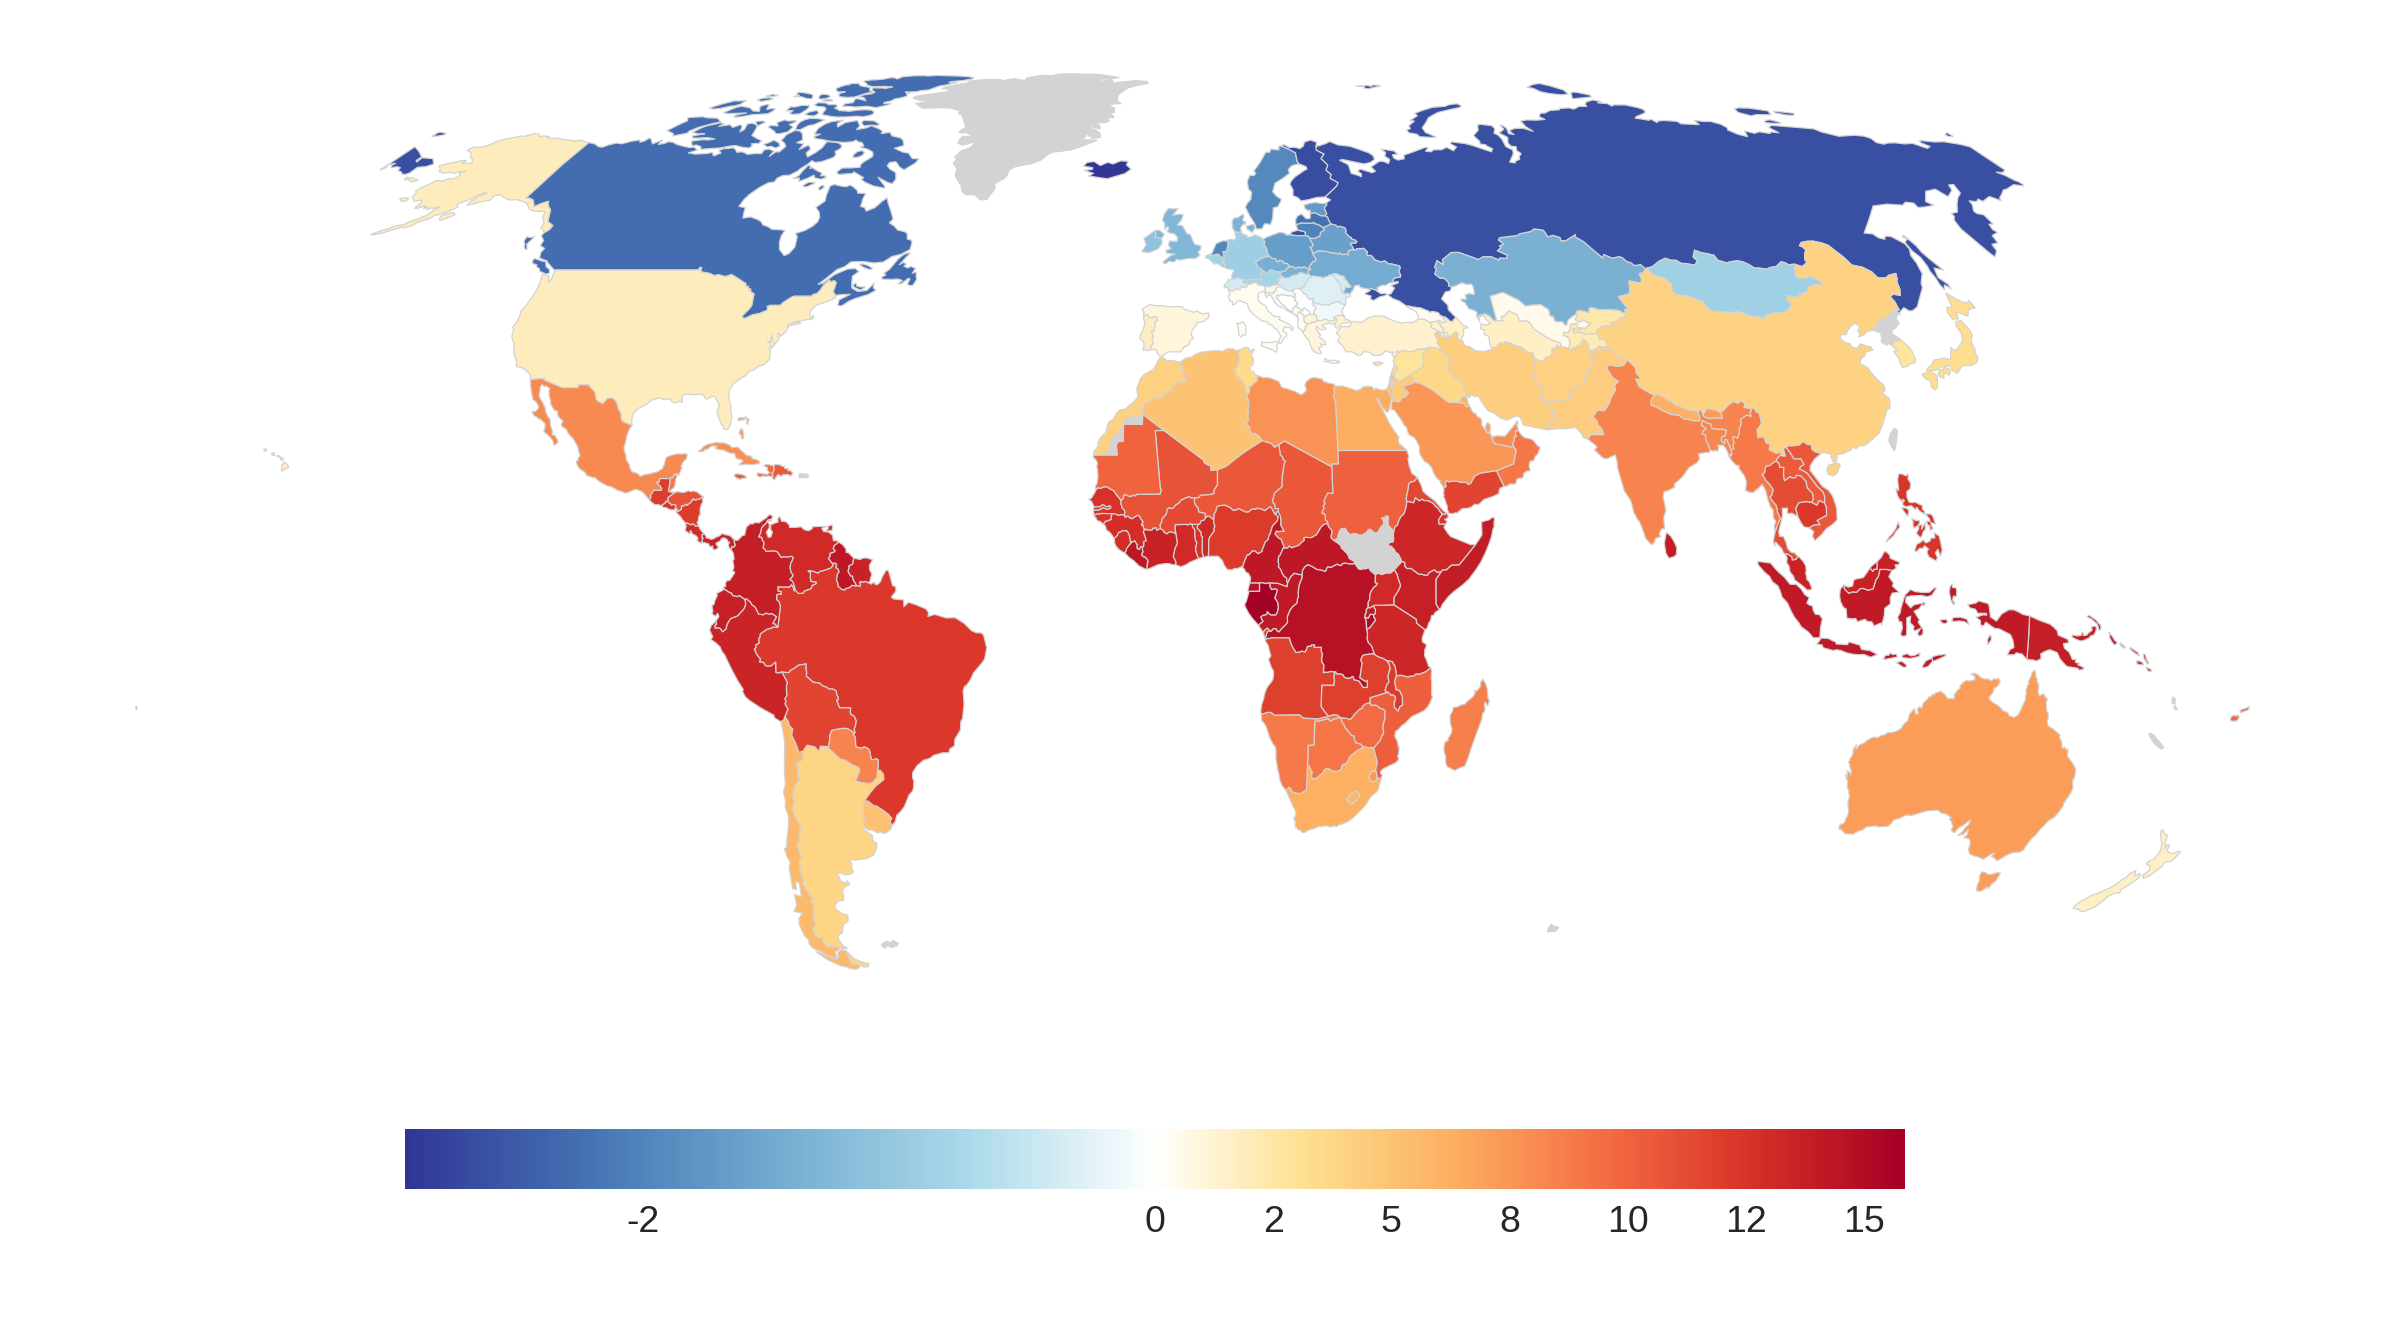

In [6]:
# Basic country-level map for year 2100
out_path = map_viz.plot_country_map(
    data=f2_df,
    value_col="flextotal",
    geo_id_col="iso3",
    year=2100,
    year_col="year",
    title="Total Flex Damage",
    units="% GDP",
    cmap_style="degree_days",
    filename="country_flextotal_2100.png"
)

if out_path:
    display(Image(filename=out_path))

2026-01-15 16:14:55 | INFO     | flexdamage.diagnostics.maps | Filtered to year 2100: 168 records
2026-01-15 16:14:55 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/maps/country_flextotal_clipped.png
2026-01-15 16:14:55 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/maps/country_flextotal_clipped_stats.csv


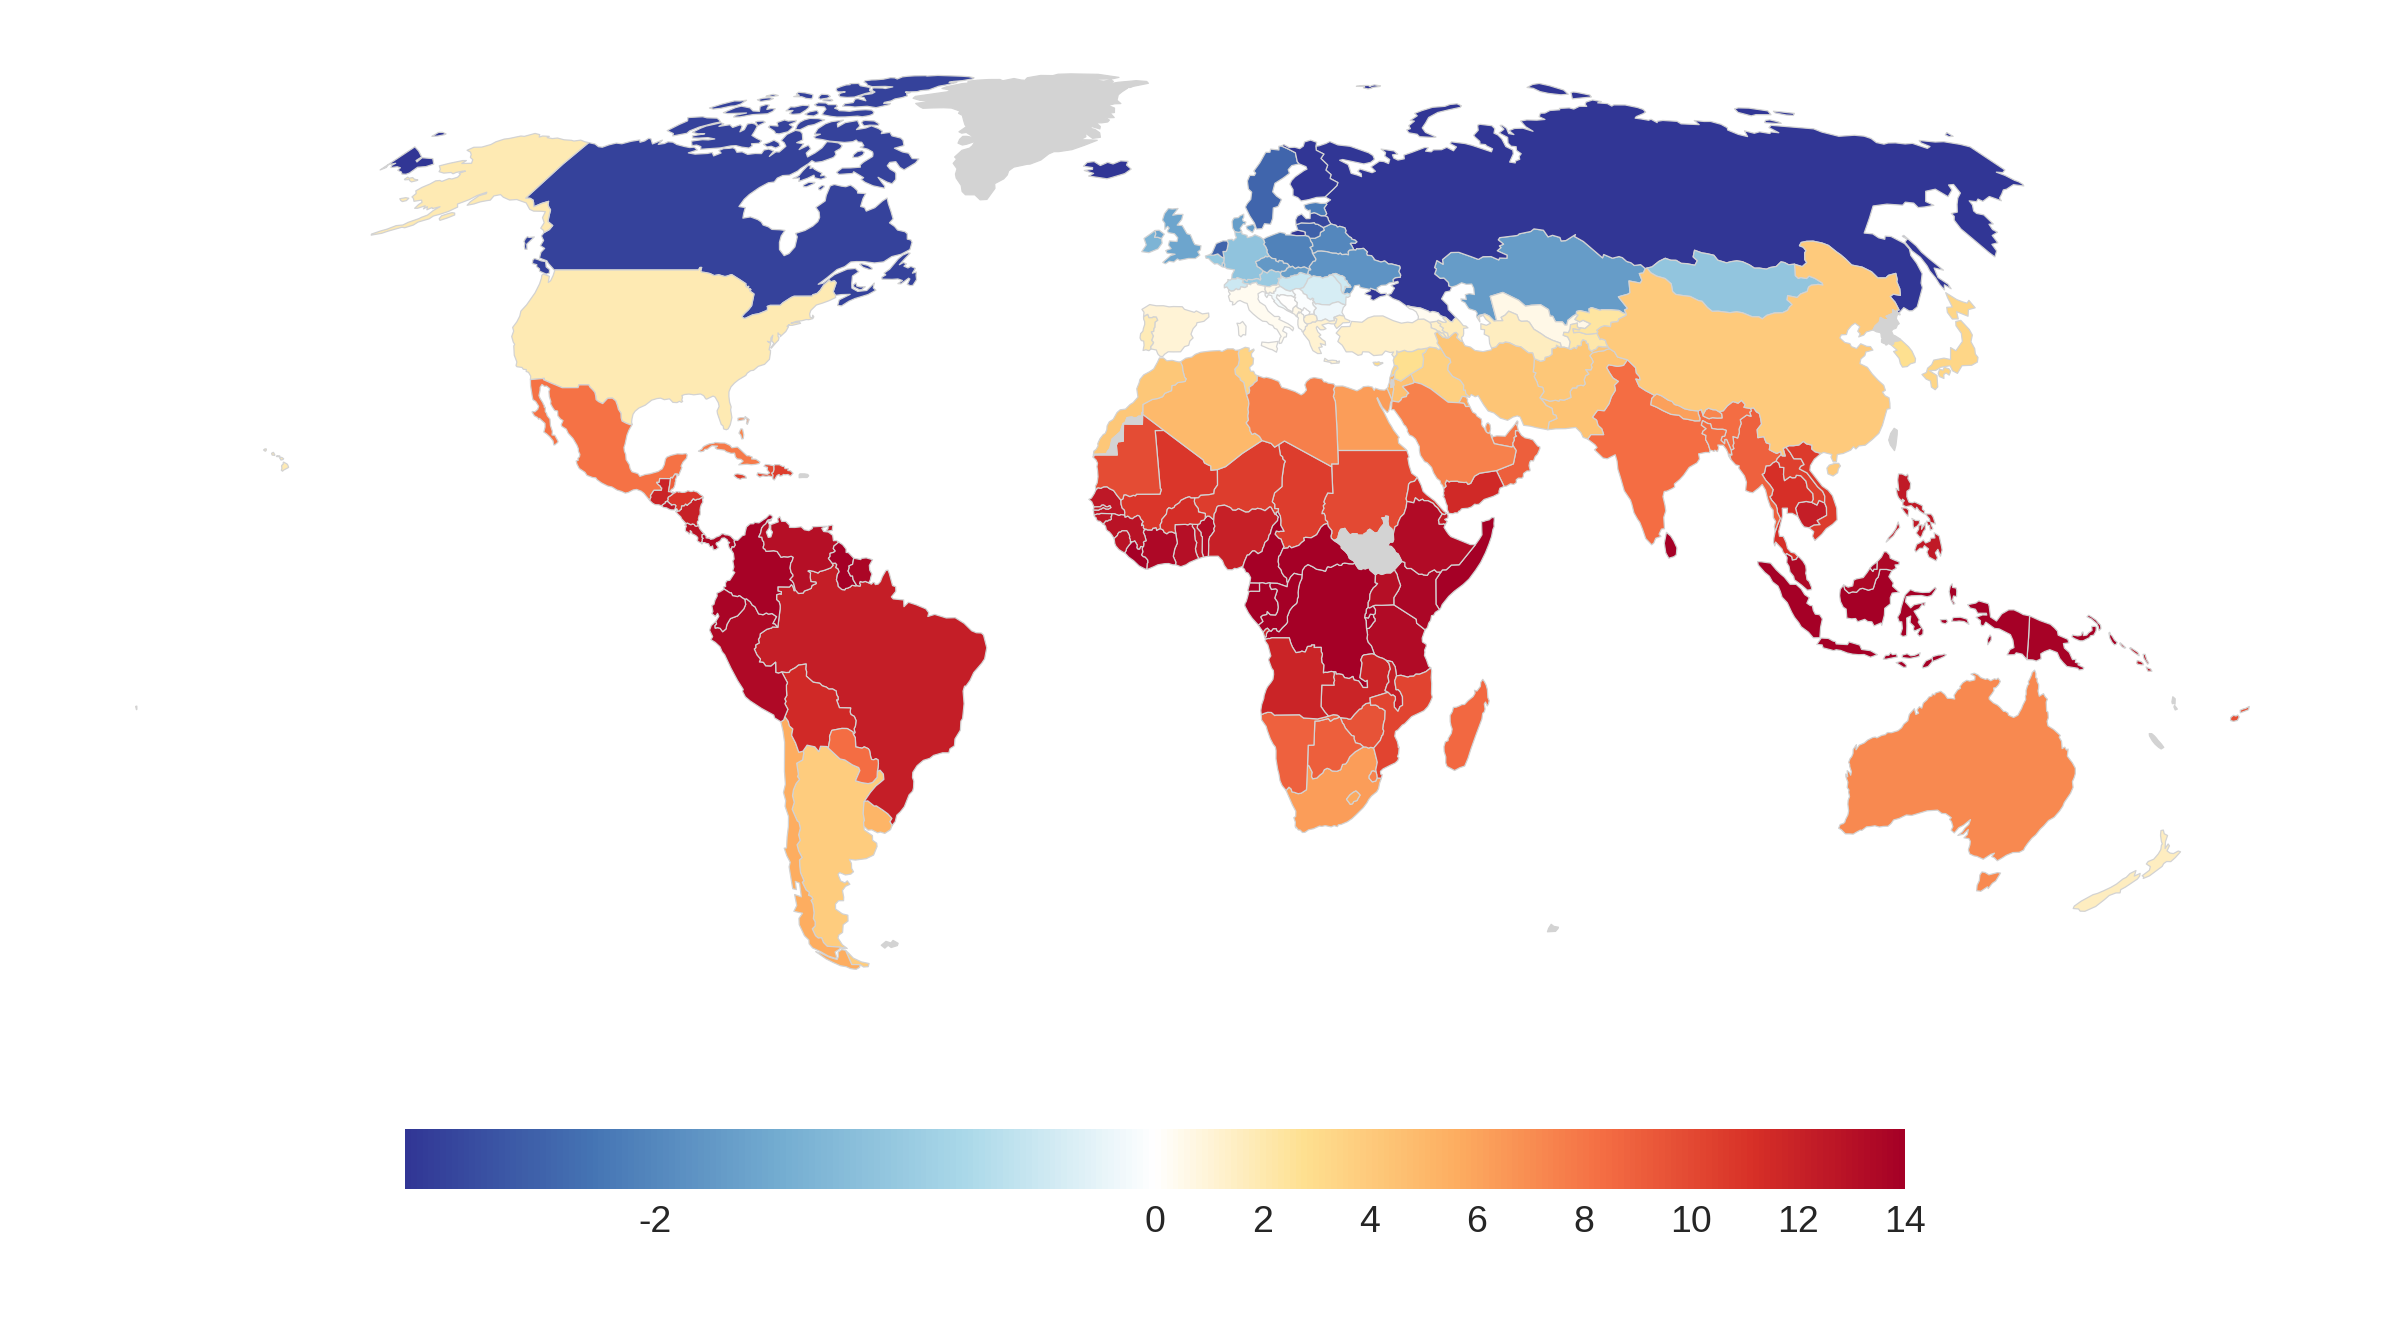

In [7]:
# Map with clipped values (topcoding/bottomcoding)
out_path = map_viz.plot_country_map(
    data=f2_df,
    value_col="flextotal",
    geo_id_col="iso3",
    year=2100,
    vmin=-3,  # Values below this show as minimum color
    vmax=14,   # Values above this show as maximum color
    title="Flex Damage (Clipped Scale)",
    units="% GDP",
    filename="country_flextotal_clipped.png"
)

if out_path:
    display(Image(filename=out_path))

2026-01-15 16:14:55 | INFO     | flexdamage.diagnostics.maps | Filtered to year 2100: 168 records
2026-01-15 16:14:55 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/maps/country_rawtotal_2100.png
2026-01-15 16:14:55 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/maps/country_rawtotal_2100_stats.csv


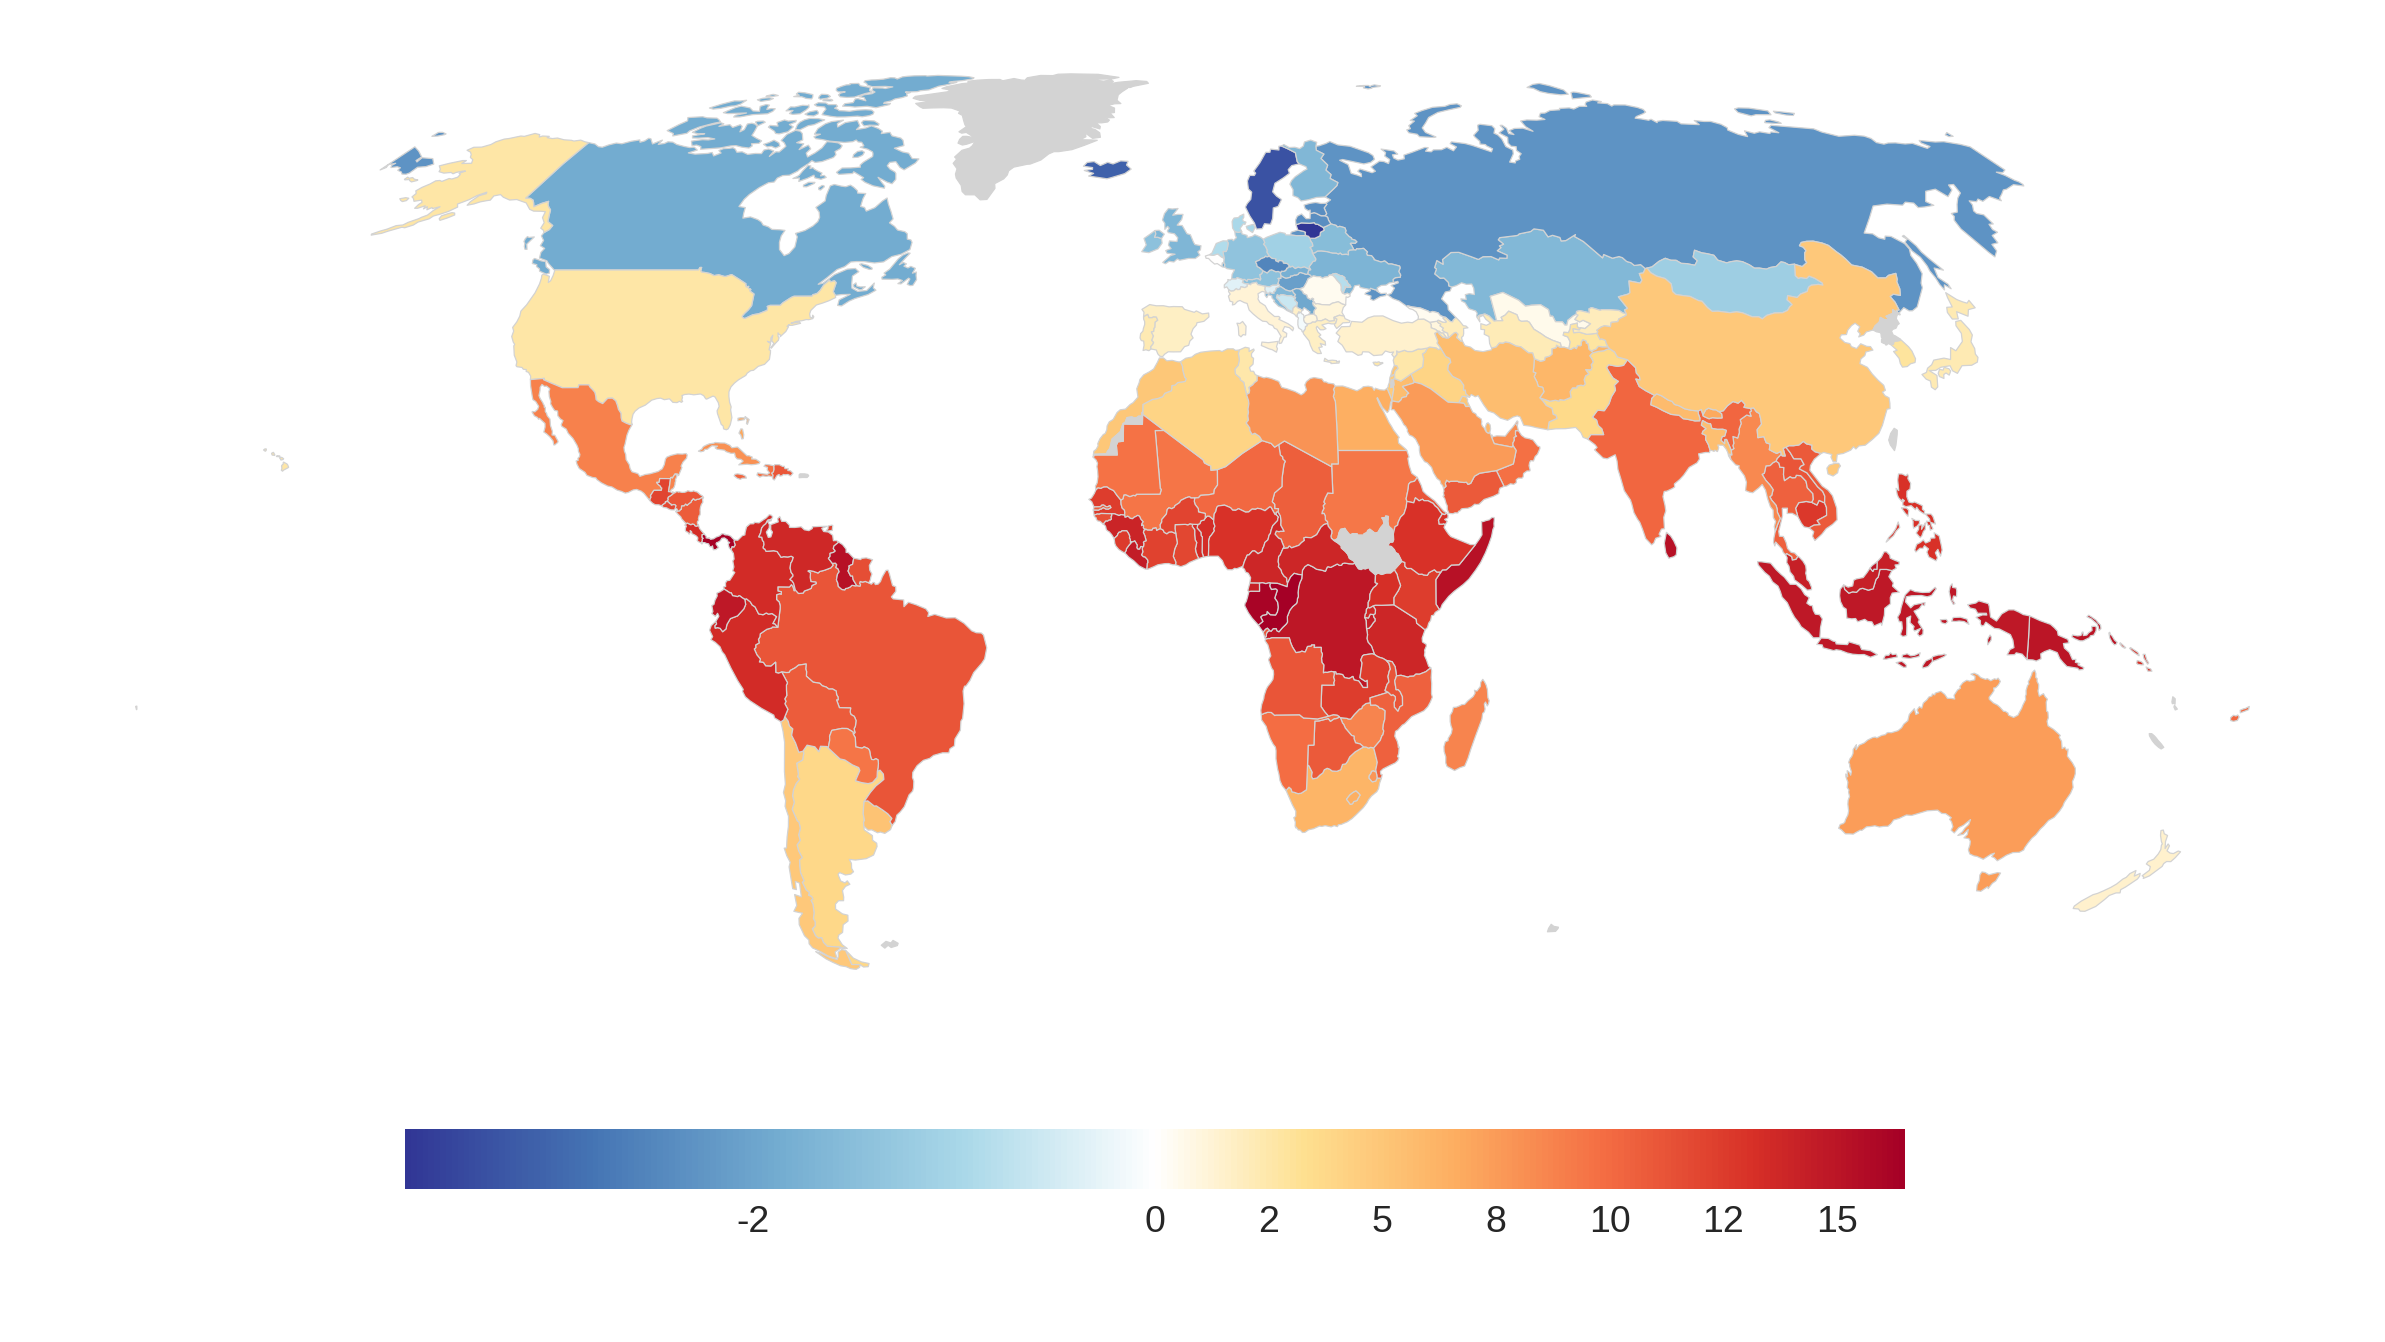

In [8]:
# Map of raw total for comparison
out_path = map_viz.plot_country_map(
    data=f2_df,
    value_col="rawtotal",
    geo_id_col="iso3",
    year=2100,
    title="Raw Total Damage",
    units="% GDP",
    cmap_style="degree_days",
    filename="country_rawtotal_2100.png"
)

if out_path:
    display(Image(filename=out_path))

## 4. Comparison Maps

Compare two value columns (e.g., `flextotal` vs `rawtotal`) to assess:
- **Sign agreement**: Do both predictions have the same sign?
- **Magnitude difference**: How different are the predictions?

Colors:
- **Green**: Sign match (both positive or both negative)
- **Red**: Sign mismatch (different signs)
- **Intensity**: Magnitude of difference

2026-01-15 16:14:55 | INFO     | flexdamage.diagnostics.maps | Filtered to year 2100: 168 records
2026-01-15 16:14:56 | INFO     | flexdamage.diagnostics.maps | Saved comparison map to map_output/maps/comparison_flex_vs_raw_2100.png
2026-01-15 16:14:56 | INFO     | flexdamage.diagnostics.maps | Saved comparison stats to map_output/maps/comparison_flex_vs_raw_2100_stats.csv


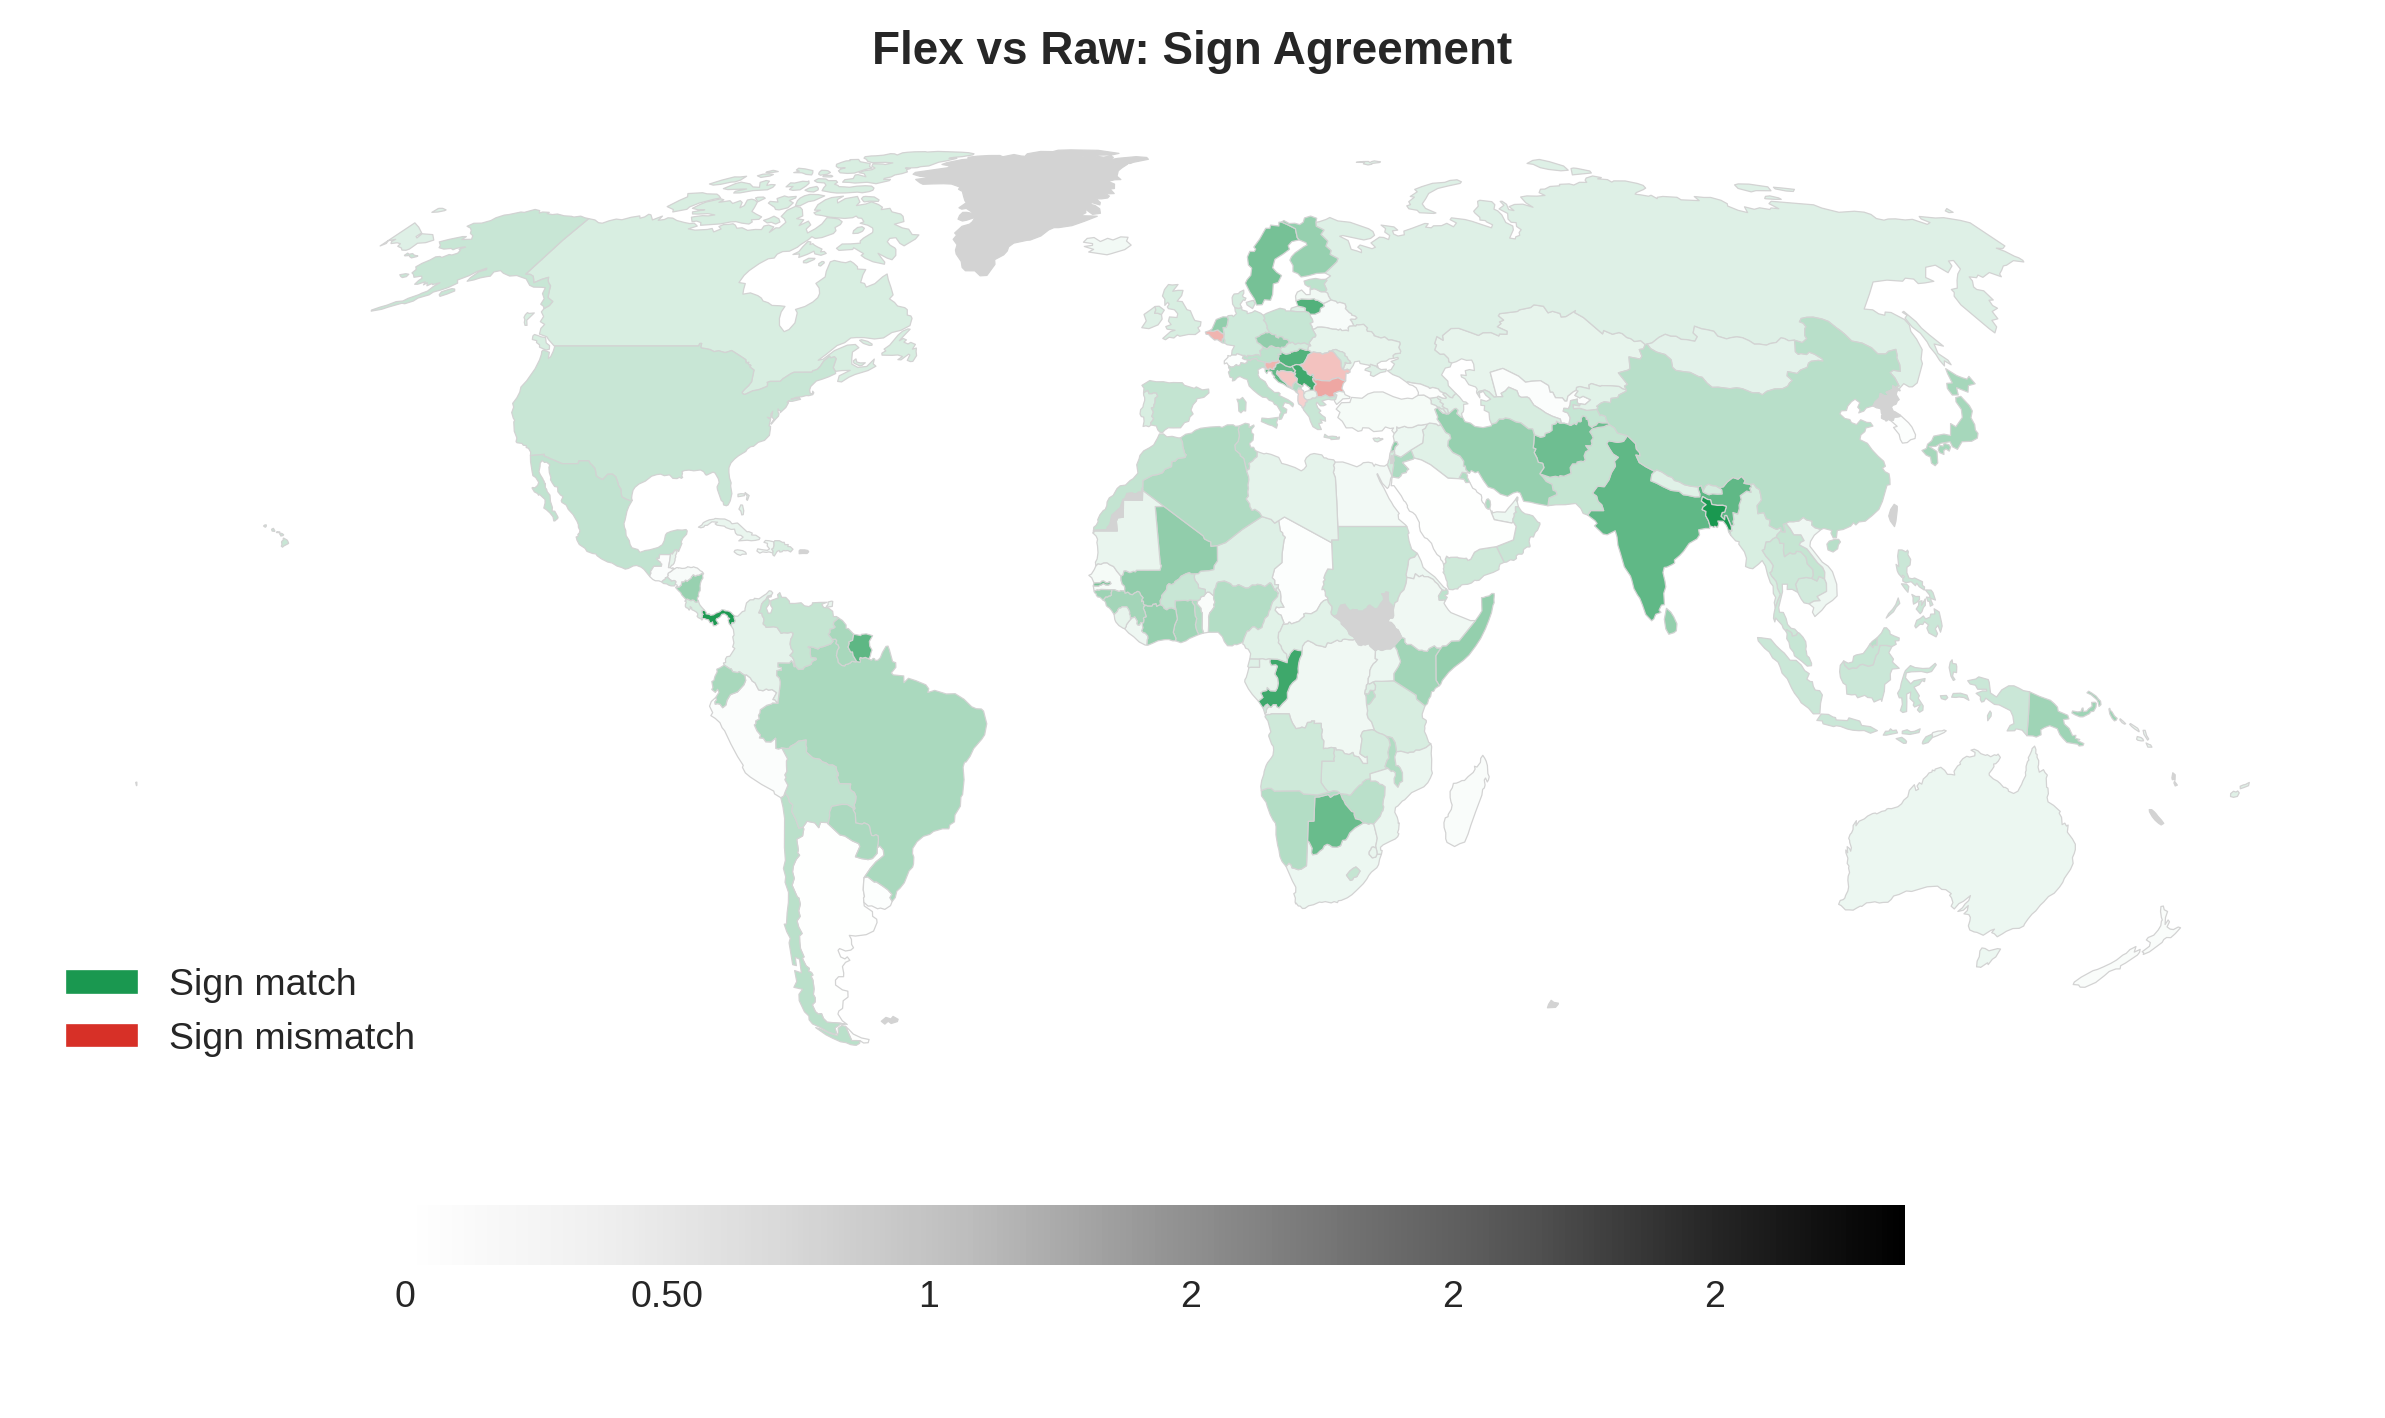

In [9]:
# Comparison map: flextotal vs rawtotal
out_path = map_viz.plot_comparison_map(
    data=f2_df,
    value_col_a="flextotal",
    value_col_b="rawtotal",
    geo_id_col="iso3",
    geo_level="country",
    year=2100,
    title="Flex vs Raw: Sign Agreement",
    filename="comparison_flex_vs_raw_2100.png"
)

if out_path:
    display(Image(filename=out_path))

## 5. Using the Convenience Method

The `plot_f2_map()` method provides a simpler interface for common F2 table plotting.

In [10]:
# Convenience method for F2 data
out_path = map_viz.plot_f2_map(
    f2_data=f2_df,
    value_col="flextotal",
    geo_level="country",
    geo_id_col="iso3",
    year=2080,
    title="Flex Damage 2080",
    units="% GDP",
    filename="f2_flextotal_2080.png"
)

if out_path:
    display(Image(filename=out_path))

2026-01-15 16:14:56 | INFO     | flexdamage.diagnostics.maps | Filtered to year 2080: 0 records
2026-01-15 16:14:56 | WARNING  | flexdamage.diagnostics.maps | No valid data values for mapping


## 6. Regional/Subnational Maps

For subnational maps, you need to provide:
1. A shapefile with regional geometries
2. The ID column in the shapefile (`shape_id_col`)
3. The matching ID column in your data (`geo_id_col`)

### Example shapefile path:
```
/Volumes/cil/sacagawea_shares/gcp/climate/_spatial_data/world-combo-new-nytimes/new_shapefile.shp
```

In [11]:
# Create mock regional data
# Using 'hierid' format typical for GCP shapefiles

# Example regional IDs (simplified)
regional_ids = [
    "USA.1.1", "USA.2.1", "USA.3.1", "USA.4.1", "USA.5.1",
    "CAN.1.1", "CAN.2.1", "CAN.3.1",
    "MEX.1.1", "MEX.2.1", "MEX.3.1",
    "BRA.1.1", "BRA.2.1", "BRA.3.1", "BRA.4.1",
    "CHN.1.1", "CHN.2.1", "CHN.3.1", "CHN.4.1", "CHN.5.1",
]

regional_data = pd.DataFrame({
    "region": regional_ids,
    "year": 2100,
    "flextotal": np.random.uniform(-0.5, 2.0, len(regional_ids)),
    "rawtotal": np.random.uniform(-0.3, 1.8, len(regional_ids)),
})

print("Mock regional data:")
regional_data.head()

Mock regional data:


,region,year,flextotal,rawtotal
0,USA.1.1,2100,0.433461,1.420956
1,USA.2.1,2100,1.283114,0.190255
2,USA.3.1,2100,-0.316032,1.680863
3,USA.4.1,2100,0.503628,0.384199
4,USA.5.1,2100,0.033783,1.420142


2026-01-15 16:14:56 | INFO     | flexdamage.diagnostics.maps | Filtered to year 2100: 20 records
2026-01-15 16:14:56 | INFO     | flexdamage.diagnostics.maps | Loading shapefile: /project/cil/sacagawea_shares/gcp/climate/_spatial_data/world-combo-new-nytimes/new_shapefile.shp


/project/cil/home_dirs/scadavidsanchez/envs/regional-scc-df-fit/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: /project/cil/sacagawea_shares/gcp/climate/_spatial_data/world-combo-new-nytimes/new_shapefile.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


2026-01-15 16:14:56 | INFO     | flexdamage.diagnostics.maps | Loaded 24377 geometries from shapefile
2026-01-15 16:15:01 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/maps/regional_flextotal_2100.png
2026-01-15 16:15:01 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/maps/regional_flextotal_2100_stats.csv


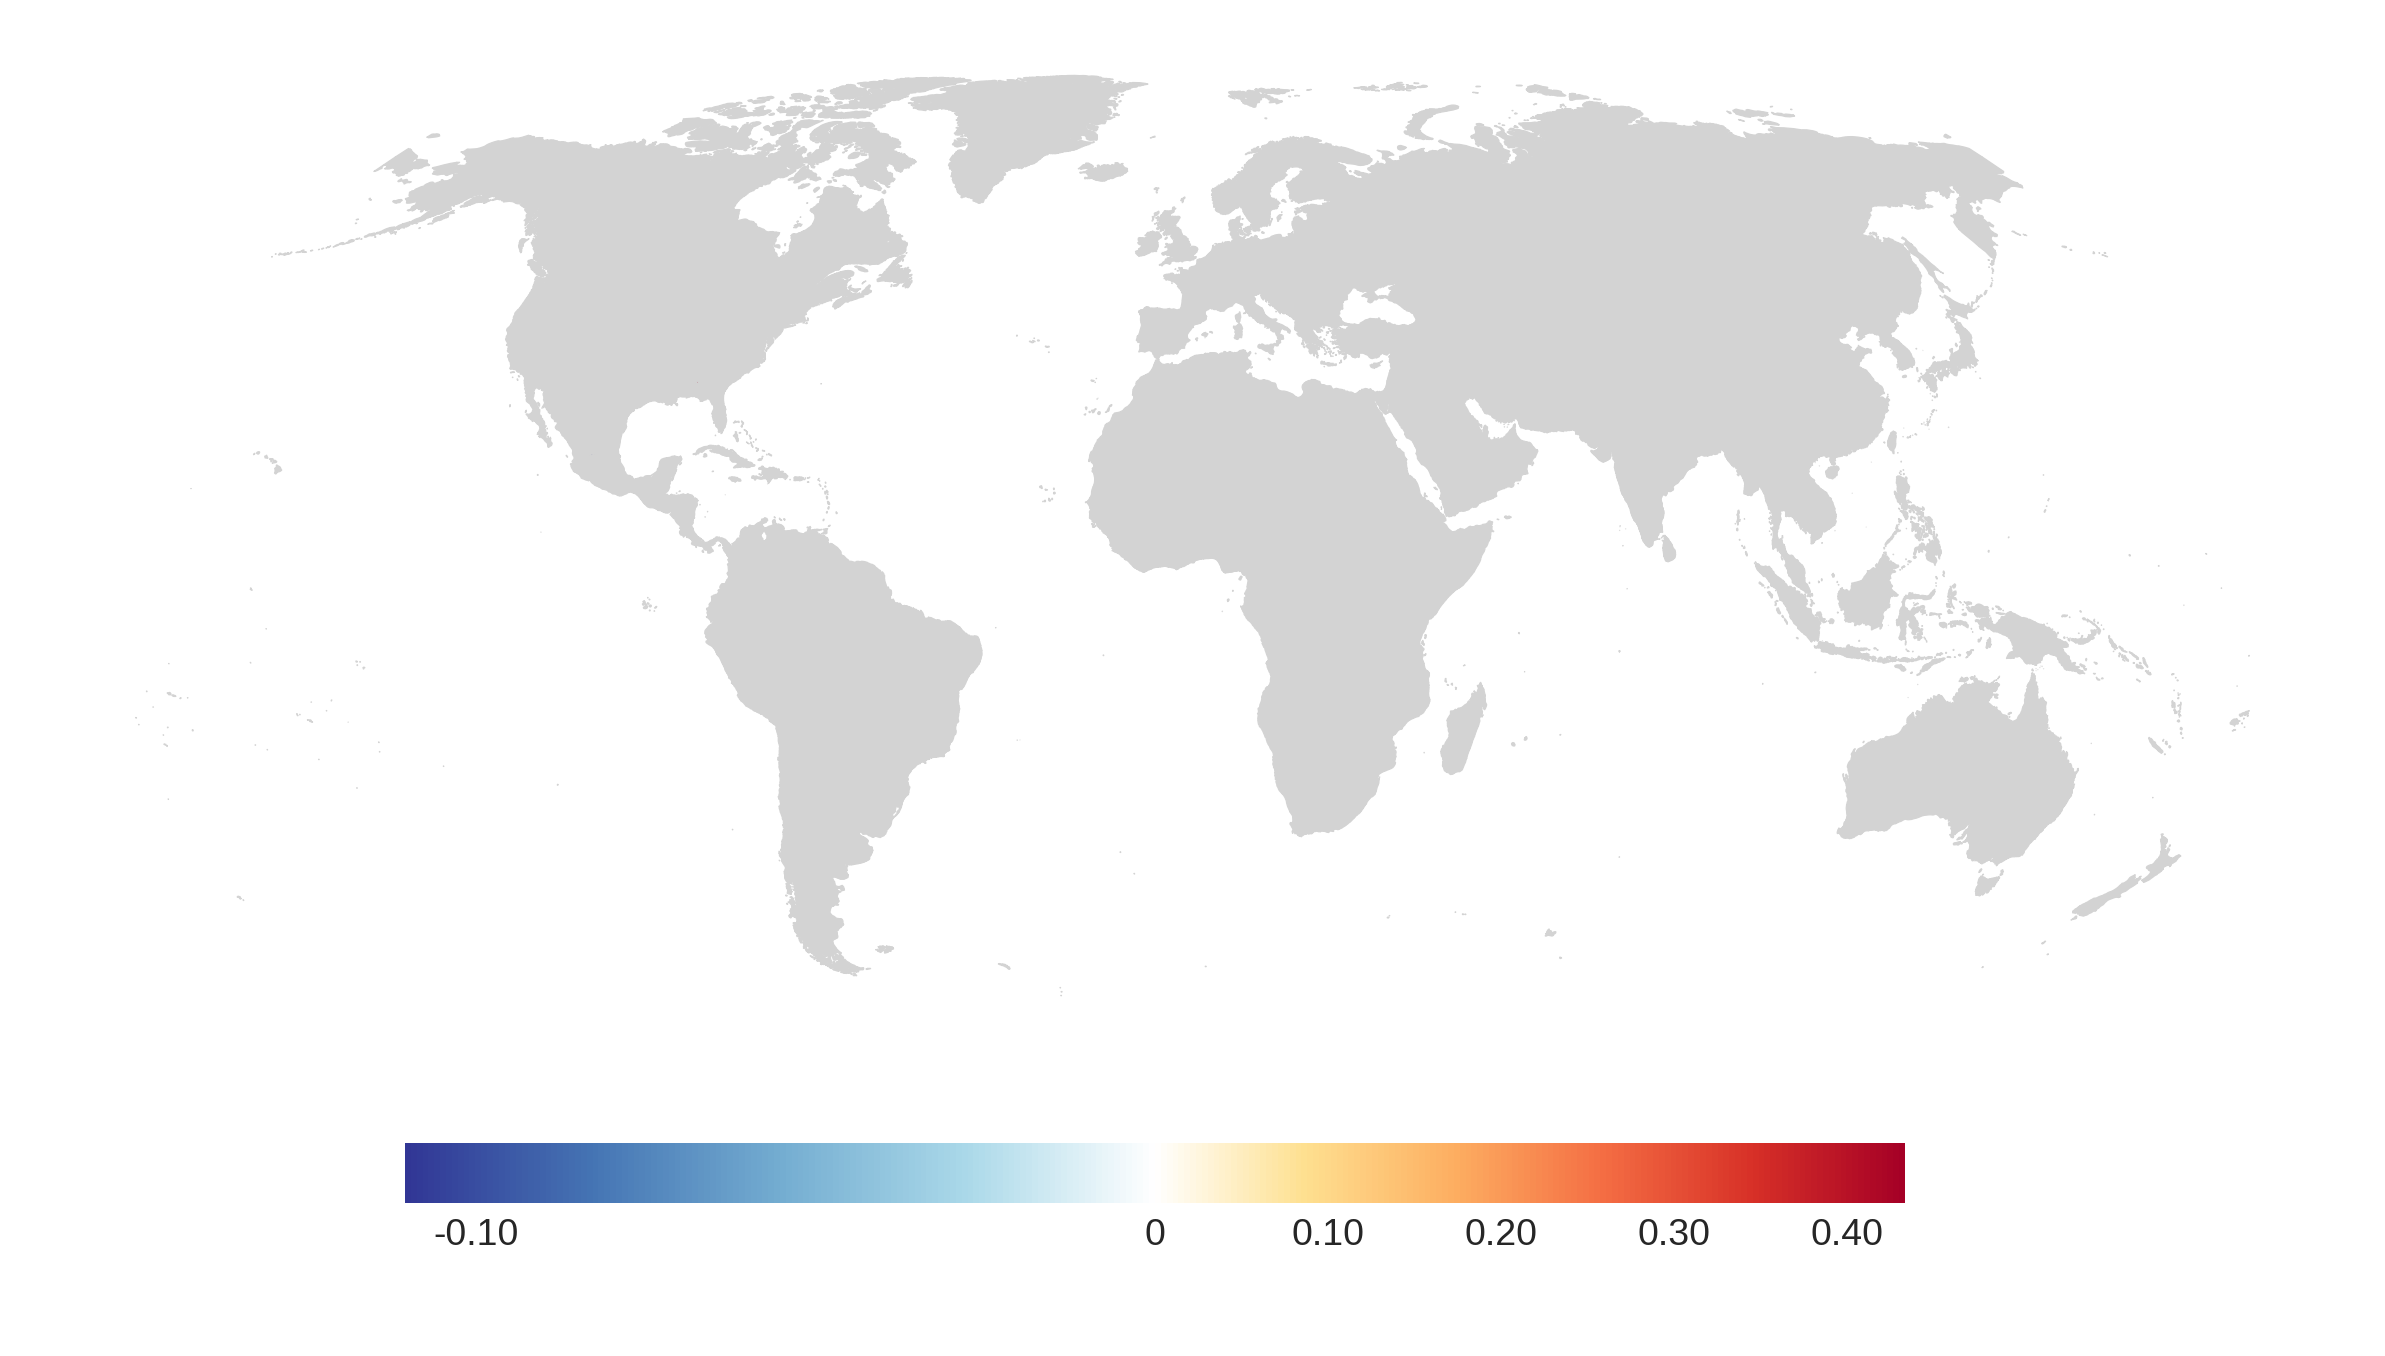

In [12]:
# Regional map (requires actual shapefile)
# Uncomment and adjust paths as needed

import os

SHAPEFILE_PATH = "/project/cil/sacagawea_shares/gcp/climate/_spatial_data/world-combo-new-nytimes/new_shapefile.shp"
if not os.path.exists(SHAPEFILE_PATH):
    SHAPEFILE_PATH = SHAPEFILE_PATH.replace("/project/cil", "/Volumes/cil", 1)

# Check if shapefile exists
from pathlib import Path
if Path(SHAPEFILE_PATH).exists():
    out_path = map_viz.plot_regional_map(
        data=regional_data,
        shapefile_path=SHAPEFILE_PATH,
        value_col="flextotal",
        geo_id_col="region",
        shape_id_col="hierid",  # Column name in shapefile
        year=2100,
        title="Regional Flex Damage",
        units="% GDP",
        exclude_patterns=["ATA"],  # Exclude Antarctica
        filename="regional_flextotal_2100.png"
    )
    if out_path:
        display(Image(filename=out_path))
else:
    print(f"Shapefile not found at: {SHAPEFILE_PATH}")
    print("Skipping regional map example.")

## 7. Statistics Output

Each map automatically saves statistics CSV files showing:
- Top 10 / Bottom 10 regions by value
- For comparison maps: Best/Worst alignment statistics

In [13]:
# View saved statistics
stats_dir = output_dir / "maps"

import os
stats_files = [f for f in os.listdir(stats_dir) if f.endswith("_stats.csv")]
print(f"Statistics files generated: {stats_files}")

# Display one of them
if stats_files:
    stats_df = pd.read_csv(stats_dir / stats_files[0])
    print(f"\nContents of {stats_files[0]}:")
    display(stats_df)

Statistics files generated: ['country_presentation_style_stats.csv', 'comparison_flex_vs_raw_2100_stats.csv', 'country_flextotal_2100_stats.csv', 'country_flextotal_clipped_stats.csv', 'regional_flextotal_2100_stats.csv', 'f2_flextotal_2080_stats.csv', 'country_rawtotal_2100_stats.csv']

Contents of country_presentation_style_stats.csv:


,iso3,flextotal,Category
0,ISL,-3.6607,Bottom 10
1,FIN,-3.3431,Bottom 10
2,RUS,-3.2875,Bottom 10
3,CAN,-2.8367,Bottom 10
4,LVA,-2.7977,Bottom 10
5,LTU,-2.5019,Bottom 10
6,NLD,-2.4381,Bottom 10
7,SWE,-2.4288,Bottom 10
8,EST,-2.1374,Bottom 10
9,POL,-2.0848,Bottom 10


## 8. Changing Styles

You can switch between 'scientific' and 'presentation' styles.

2026-01-15 16:15:01 | INFO     | flexdamage.diagnostics.maps | Filtered to year 2100: 168 records
2026-01-15 16:15:01 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/maps/country_presentation_style.png
2026-01-15 16:15:01 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/maps/country_presentation_style_stats.csv


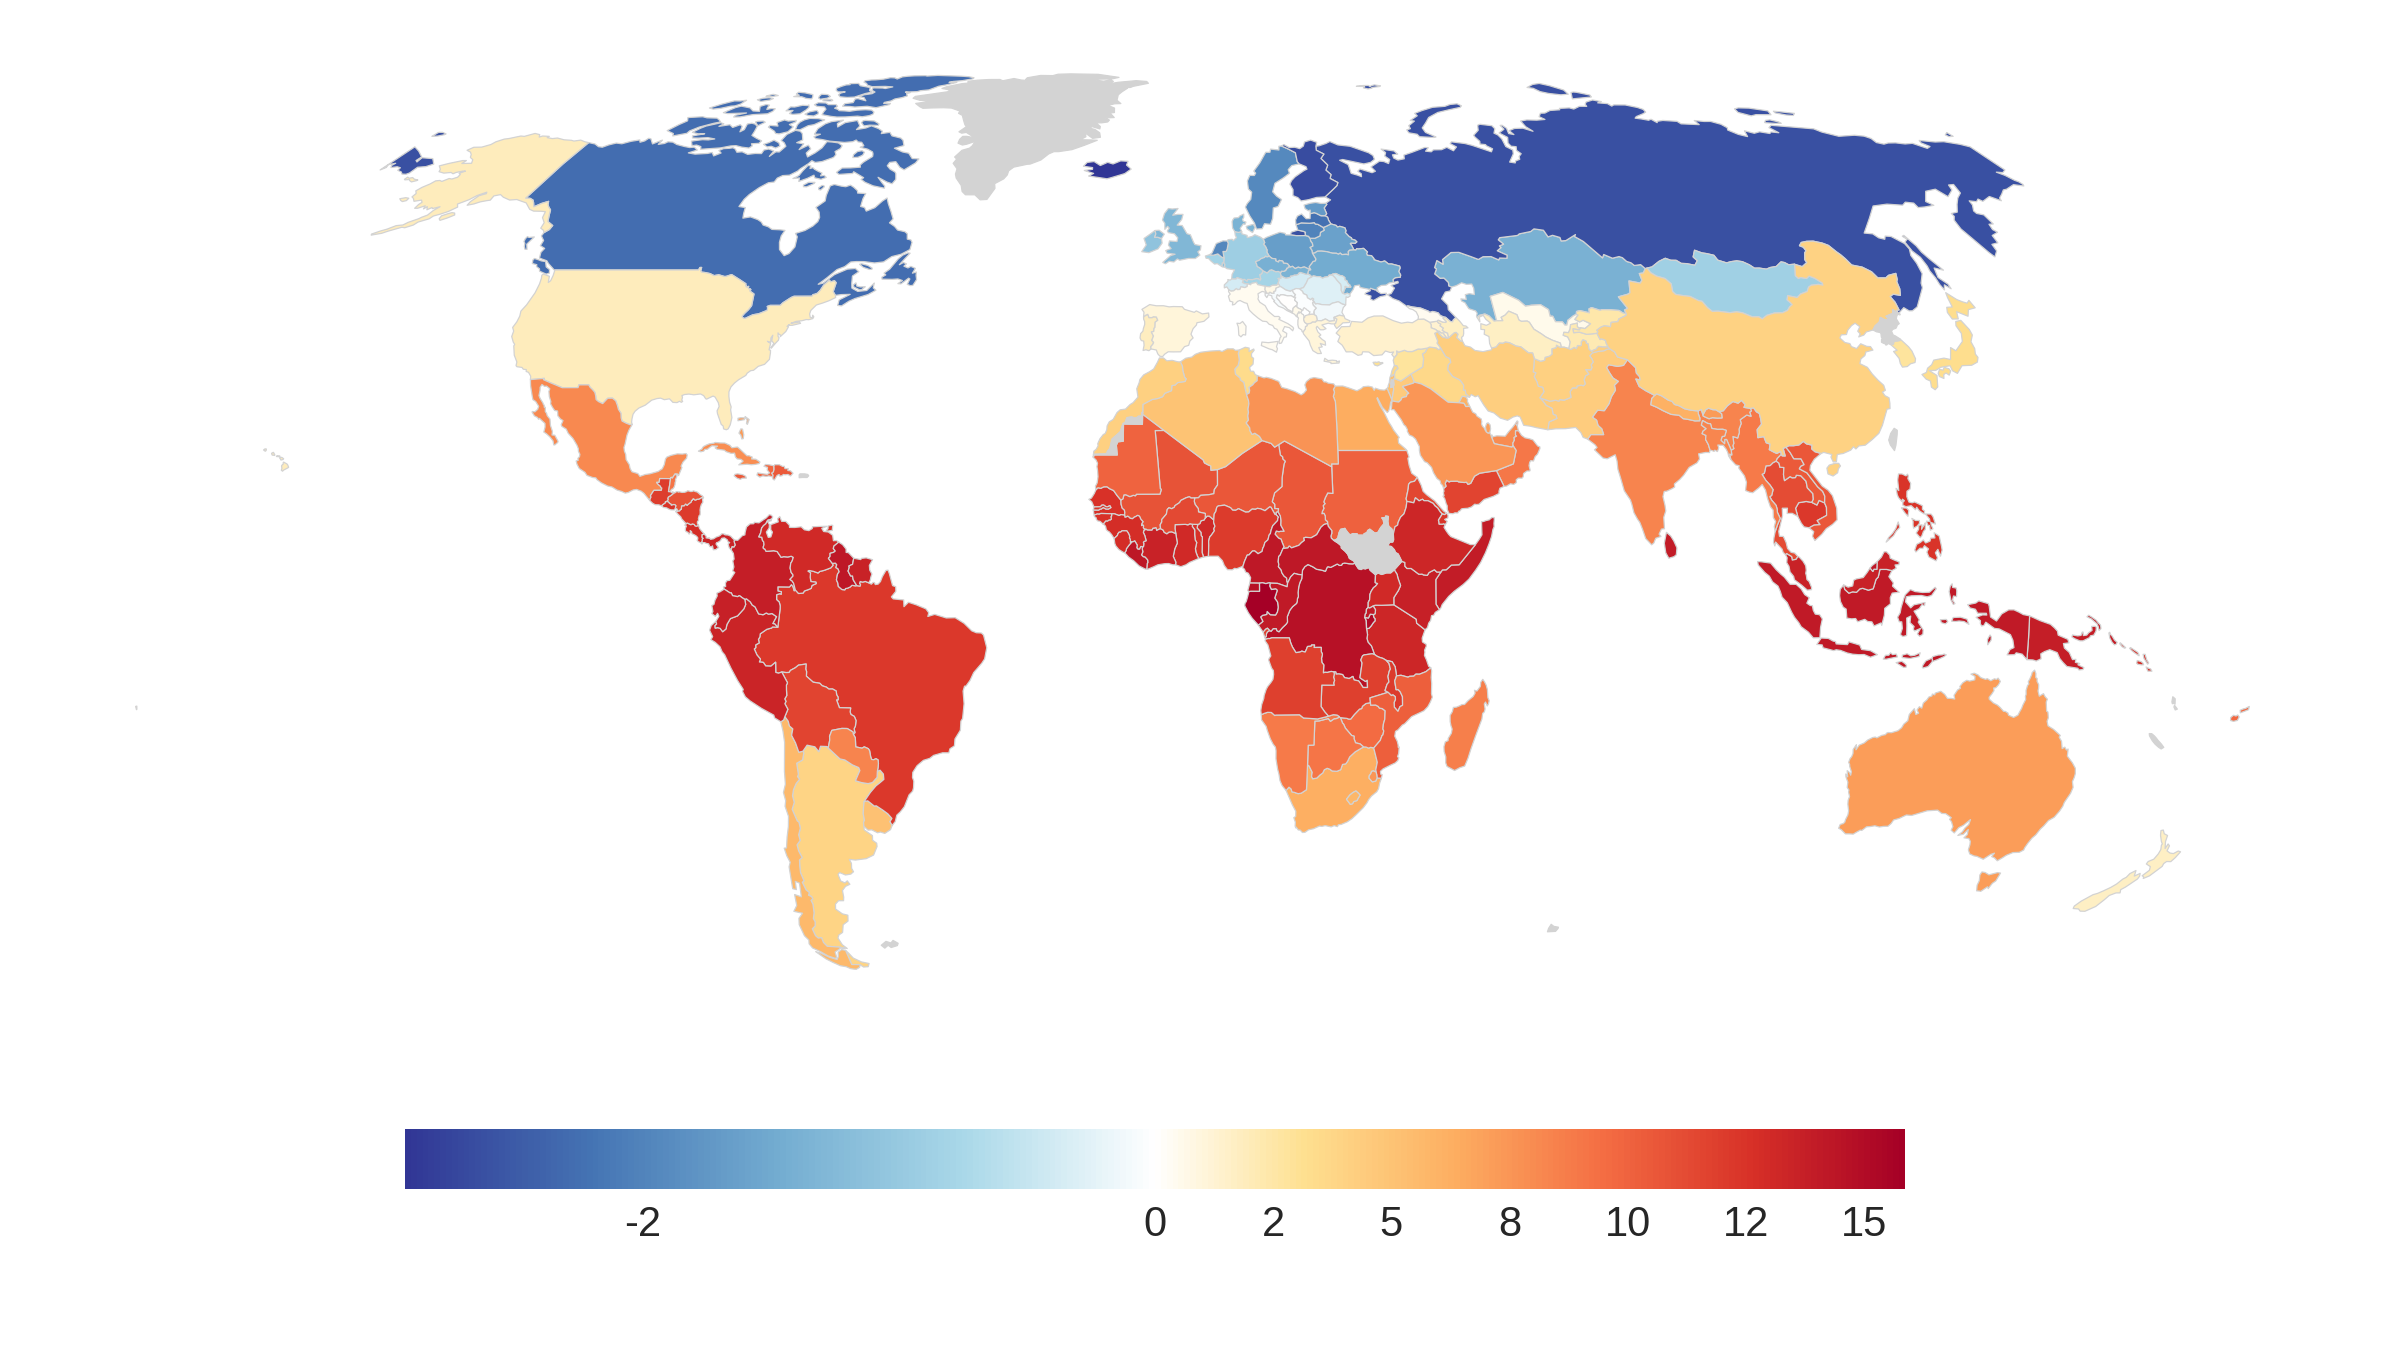

In [14]:
# Switch to presentation style
map_viz.set_style("presentation")

out_path = map_viz.plot_country_map(
    data=f2_df,
    value_col="flextotal",
    geo_id_col="iso3",
    year=2100,
    title="Flex Damage (Presentation Style)",
    filename="country_presentation_style.png"
)

if out_path:
    display(Image(filename=out_path))

# Switch back to scientific
map_viz.set_style("scientific")

## Summary

### Key Methods

| Method | Use Case |
|--------|----------|
| `plot_country_map()` | Country-level maps (auto-fetch geometries) |
| `plot_regional_map()` | Subnational maps (requires shapefile) |
| `plot_comparison_map()` | Two-column diagnostic (sign agreement) |
| `plot_f2_map()` | Convenience wrapper for F2 tables |

### Key Parameters

| Parameter | Description |
|-----------|-------------|
| `value_col` | Column containing values to plot |
| `geo_id_col` | Column with geographic identifiers |
| `year` | Filter data by year (optional) |
| `vmin/vmax` | Color scale limits (topcoding/bottomcoding) |
| `units` | Units for legend label |
| `cmap_style` | Color scheme: 'standard', 'degree_days', 'diverging' |

### Outputs

- PNG map image (300 DPI)
- Statistics CSV (Top 10 / Bottom 10 regions)

In [15]:
# List all generated outputs
print("Generated files:")
for f in sorted(os.listdir(output_dir / "maps")):
    print(f"  {f}")

Generated files:
  comparison_flex_vs_raw_2100.png
  comparison_flex_vs_raw_2100_stats.csv
  country_flextotal_2100.png
  country_flextotal_2100_stats.csv
  country_flextotal_clipped.png
  country_flextotal_clipped_stats.csv
  country_presentation_style.png
  country_presentation_style_stats.csv
  country_rawtotal_2100.png
  country_rawtotal_2100_stats.csv
  f2_flextotal_2080.png
  f2_flextotal_2080_stats.csv
  regional_flextotal_2100.png
  regional_flextotal_2100_stats.csv


## 9. Real Data Examples

This section demonstrates map generation using actual F2 tables from the examples directory.

### Country-Level Mortality Data (SSP2)

The dataset `countries_mortality_SSP2.csv` contains:
- 245 countries (ISO-3 codes)
- 2 RCP scenarios: rcp45, rcp85
- 2 models: high, low  
- 5 time periods: 2020_2039, 2040_2059, 2060_2079, 2080_2094, 2095_2100

In [16]:
# Load the real country-level mortality data
country_mortality_path = "../dataset/f2_examples/countries_mortality_SSP2.csv"
country_mortality_df = pd.read_csv(country_mortality_path)

print(f"Shape: {country_mortality_df.shape}")
print(f"Columns: {list(country_mortality_df.columns)}")
print(f"\nUnique values:")
print(f"  RCPs: {sorted(country_mortality_df['rcp'].unique())}")
print(f"  Models: {sorted(country_mortality_df['model'].unique())}")
print(f"  Periods: {sorted(country_mortality_df['period'].unique())}")
print(f"  Countries: {country_mortality_df['iso'].nunique()}")
print(f"\nValue ranges:")
print(f"  flextotal: [{country_mortality_df['flextotal'].min():.2f}, {country_mortality_df['flextotal'].max():.2f}]")
print(f"  rawtotal: [{country_mortality_df['rawtotal'].min():.2f}, {country_mortality_df['rawtotal'].max():.2f}]")
country_mortality_df.head()

Shape: (4900, 11)
Columns: ['iso', 'rcp', 'ssp', 'model', 'period', 'year_center', 'TT', 'flextotal', 'rawtotal', 'f2mort', 'f2total']

Unique values:
  RCPs: ['rcp45', 'rcp85']
  Models: ['high', 'low']
  Periods: ['2020_2039', '2040_2059', '2060_2079', '2080_2094', '2095_2100']
  Countries: 245

Value ranges:
  flextotal: [-202.09, 133.97]
  rawtotal: [-220.21, 252.31]


,iso,rcp,ssp,model,period,year_center,TT,flextotal,rawtotal,f2mort,f2total
0,ABW,rcp45,SSP2,low,2020_2039,2039,1.604874,-8.960070,2.858468,NaN,NaN
1,ABW,rcp45,SSP2,low,2040_2059,2059,1.973922,-5.696377,0.658367,NaN,NaN
2,ABW,rcp45,SSP2,low,2060_2079,2079,2.186925,-3.589938,-0.954116,NaN,NaN
3,ABW,rcp45,SSP2,low,2080_2094,2094,2.299085,-2.515015,-1.831327,NaN,NaN
4,ABW,rcp45,SSP2,low,2095_2100,2100,2.323768,-2.149808,-2.220099,NaN,NaN


### Generate Maps for All Combinations

Let's create static maps for each combination of RCP, model, and period.

In [17]:
# Create output directory for country mortality maps
country_output_dir = output_dir / "country_mortality"
country_output_dir.mkdir(exist_ok=True)

# Initialize map visualizer for this section
country_map_viz = MapVisualizer(
    output_dir=country_output_dir,
    style="scientific"
)

# Get unique combinations
rcps = sorted(country_mortality_df['rcp'].unique())
models = sorted(country_mortality_df['model'].unique())
periods = sorted(country_mortality_df['period'].unique())

print(f"Will generate maps for {len(rcps)} RCPs × {len(models)} models × {len(periods)} periods = {len(rcps)*len(models)*len(periods)} maps")

# Calculate global min/max for consistent color scale
vmin_global = country_mortality_df['flextotal'].quantile(0.02)  # 2nd percentile to handle outliers
vmax_global = country_mortality_df['flextotal'].quantile(0.98)  # 98th percentile
print(f"Global color scale: [{vmin_global:.2f}, {vmax_global:.2f}]")

Will generate maps for 2 RCPs × 2 models × 5 periods = 20 maps
Global color scale: [-102.48, 69.76]


In [18]:
# Generate maps for all combinations
generated_maps = []

for rcp in rcps:
    for model in models:
        for period in periods:
            # Filter data for this combination
            mask = (
                (country_mortality_df['rcp'] == rcp) & 
                (country_mortality_df['model'] == model) & 
                (country_mortality_df['period'] == period)
            )
            subset_df = country_mortality_df[mask].copy()
            
            if len(subset_df) == 0:
                continue
            
            # Generate filename
            filename = f"mortality_{rcp}_{model}_{period}.png"
            
            # Generate map
            out_path = country_map_viz.plot_country_map(
                data=subset_df,
                value_col="flextotal",
                geo_id_col="iso",
                title=f"Mortality Damage: {rcp.upper()}, {model.capitalize()} - {period}",
                units="deaths per 100k",
                vmin=vmin_global,
                vmax=vmax_global,
                cmap_style="degree_days",
                filename=filename,
                exclude_patterns=["ATA"]  # Exclude Antarctica
            )
            
            if out_path:
                generated_maps.append({
                    'rcp': rcp,
                    'model': model,
                    'period': period,
                    'path': out_path
                })

print(f"Generated {len(generated_maps)} maps")

2026-01-15 16:15:01 | INFO     | flexdamage.diagnostics.maps | Fetching country geometries from Natural Earth...
2026-01-15 16:15:01 | INFO     | flexdamage.diagnostics.maps | Fetching from Natural Earth CDN...
2026-01-15 16:15:02 | INFO     | flexdamage.diagnostics.maps | Loaded 171 country geometries
2026-01-15 16:15:02 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/country_mortality/mortality_rcp45_high_2020_2039.png
2026-01-15 16:15:02 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/country_mortality/mortality_rcp45_high_2020_2039_stats.csv
2026-01-15 16:15:02 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/country_mortality/mortality_rcp45_high_2040_2059.png
2026-01-15 16:15:02 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/country_mortality/mortality_rcp45_high_2040_2059_stats.csv
2026-01-15 16:15:03 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/country_mortality/mortality_rcp45

In [19]:
# Display a sample of the generated maps (first period, all rcp/model combinations)
sample_period = periods[0]
sample_maps = [m for m in generated_maps if m['period'] == sample_period]

print(f"Sample maps for period {sample_period}:")
for m in sample_maps:
    print(f"  {m['rcp']} / {m['model']}")
    # display(Image(filename=m['path'], width=600))

Sample maps for period 2020_2039:
  rcp45 / high
  rcp45 / low
  rcp85 / high
  rcp85 / low


### Create Animated GIF: Country Mortality Time Series (RCP45 / Low)

This creates an animated GIF showing how country-level mortality changes over time for the RCP45/Low scenario.

Filtered data shape: (1225, 11)
Periods: ['2020_2039', '2040_2059', '2060_2079', '2080_2094', '2095_2100']
2026-01-15 16:15:08 | INFO     | flexdamage.diagnostics.maps | Creating time series GIF with 5 frames: ['2020_2039', '2040_2059', '2060_2079', '2080_2094', '2095_2100']
2026-01-15 16:15:08 | INFO     | flexdamage.diagnostics.maps | Color scale: vmin=-102.4771, vmax=69.7610
2026-01-15 16:15:10 | INFO     | flexdamage.diagnostics.maps | Saved animated GIF to map_output/country_mortality/mortality_rcp45_low_animation.gif
GIF saved to: map_output/country_mortality/mortality_rcp45_low_animation.gif


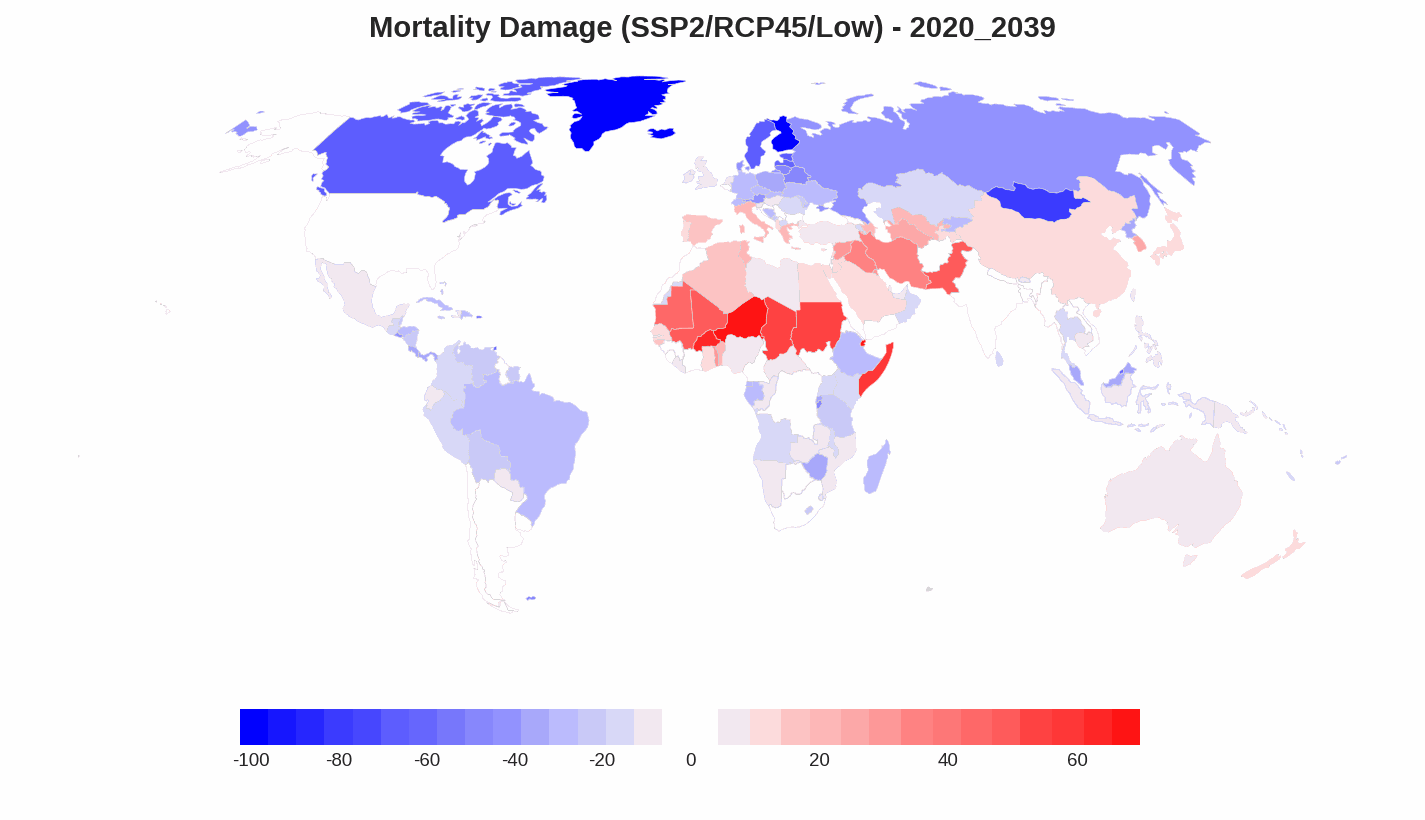

In [20]:
# Create animated GIF for a single scenario: rcp45 / low
# (Simplified time series GIF instead of grid)

# Filter to rcp45 and model=low only
country_mortality_rcp45_low = country_mortality_df[
    (country_mortality_df['rcp'] == 'rcp45') & 
    (country_mortality_df['model'] == 'low')
].copy()

print(f"Filtered data shape: {country_mortality_rcp45_low.shape}")
print(f"Periods: {sorted(country_mortality_rcp45_low['period'].unique())}")

# Create time series GIF (single panel, animated over periods)
gif_path = country_map_viz.create_time_series_gif(
    data=country_mortality_rcp45_low,
    time_col="period",
    value_col="flextotal",
    geo_level="country",
    geo_id_col="iso",
    title_template="Mortality Damage (SSP2/RCP45/Low) - {time_value}",
    units="deaths per 100k",
    vmin=vmin_global,
    vmax=vmax_global,
    duration=1500,  # 1.5 seconds per frame
    output_filename="mortality_rcp45_low_animation.gif",
    figsize=(12, 6),
    exclude_patterns=["ATA"]
)

if gif_path:
    print(f"GIF saved to: {gif_path}")
    display(Image(filename=gif_path))

### Impact Region Mortality Data (SSP3, RCP45, Low)

The dataset `ir_mortality_SSP3_rcp45_low.parquet` contains subnational (impact region) level data:
- 24,326 unique impact regions
- Fixed SSP3, RCP45, Low model scenario
- 5 time periods

In [21]:
# Load the impact region mortality data
ir_mortality_path = "../dataset/f2_examples/ir_mortality_SSP3_rcp45_low.parquet"
ir_mortality_df = pd.read_parquet(ir_mortality_path)

print(f"Shape: {ir_mortality_df.shape}")
print(f"Columns: {list(ir_mortality_df.columns)}")
print(f"\nUnique values:")
print(f"  Regions: {ir_mortality_df['region'].nunique()}")
print(f"  Periods: {sorted(ir_mortality_df['period'].unique())}")
print(f"  Year centers: {sorted(ir_mortality_df['year_center'].unique())}")
print(f"\nValue ranges:")
print(f"  flextotal: [{ir_mortality_df['flextotal'].min():.2f}, {ir_mortality_df['flextotal'].max():.2f}]")
print(f"  rawtotal: [{ir_mortality_df['rawtotal'].min():.2f}, {ir_mortality_df['rawtotal'].max():.2f}]")
print(f"\nSample regions:")
print(ir_mortality_df['region'].head(10).tolist())

Shape: (121630, 12)
Columns: ['region', 'ssp', 'rcp', 'model', 'period', 'year_center', 'TT_used', 'lgdp_diff', 'alpha', 'beta', 'flextotal', 'rawtotal']

Unique values:
  Regions: 24326
  Periods: ['2020_2039', '2040_2059', '2060_2079', '2080_2094', '2095_2100']
  Year centers: [2039, 2059, 2079, 2094, 2100]

Value ranges:
  flextotal: [7.47, 265.37]
  rawtotal: [-278.95, 211.01]

Sample regions:
['ABW', 'ABW', 'ABW', 'ABW', 'ABW', 'AFG.1.12', 'AFG.1.12', 'AFG.1.12', 'AFG.1.12', 'AFG.1.12']


In [22]:
# Create output directory for impact region maps
ir_output_dir = output_dir / "impact_region_mortality"
ir_output_dir.mkdir(exist_ok=True)

# Initialize map visualizer for this section
ir_map_viz = MapVisualizer(
    output_dir=ir_output_dir,
    style="scientific"
)

# Shapefile path for impact regions
SHAPEFILE_PATH = "/project/cil/sacagawea_shares/gcp/climate/_spatial_data/world-combo-new-nytimes/new_shapefile.shp"
if not os.path.exists(SHAPEFILE_PATH):
    SHAPEFILE_PATH = SHAPEFILE_PATH.replace("/project/cil", "/Volumes/cil", 1)

print(f"Shapefile path: {SHAPEFILE_PATH}")
print(f"Shapefile exists: {os.path.exists(SHAPEFILE_PATH)}")

Shapefile path: /project/cil/sacagawea_shares/gcp/climate/_spatial_data/world-combo-new-nytimes/new_shapefile.shp
Shapefile exists: True


### Generate Impact Region Maps for Each Period

We'll generate maps for all available periods (approximately every 20 years).

In [34]:
# Calculate global min/max for consistent color scale across all periods
ir_vmin_global = ir_mortality_df['rawtotal'].quantile(0.02)
ir_vmax_global = ir_mortality_df['rawtotal'].quantile(0.98)
print(f"Impact region color scale: [{rawtotal:.2f}, {ir_vmax_global:.2f}]")

# Get unique periods
ir_periods = sorted(ir_mortality_df['period'].unique())
print(f"Periods to map: {ir_periods}")

Impact region color scale: [8.72, 60.29]
Periods to map: ['2020_2039', '2040_2059', '2060_2079', '2080_2094', '2095_2100']


In [35]:
# Generate maps for each period (if shapefile is available)
ir_generated_maps = []

if os.path.exists(SHAPEFILE_PATH):
    for period in ir_periods:
        # Filter data for this period
        subset_df = ir_mortality_df[ir_mortality_df['period'] == period].copy()
        
        # Generate filename
        filename = f"ir_mortality_SSP3_rcp45_low_{period}.png"
        
        # Generate map
        out_path = ir_map_viz.plot_regional_map(
            data=subset_df,
            shapefile_path=SHAPEFILE_PATH,
            value_col="flextotal",
            geo_id_col="region",
            shape_id_col="hierid",
            title=f"Mortality Damage (SSP3/RCP45/Low) - {period}",
            units="deaths per 100k",
            vmin=ir_vmin_global,
            vmax=ir_vmax_global,
            cmap_style="degree_days",
            filename=filename,
            exclude_patterns=["ATA"],
            simplify_tolerance=0.01  # Simplify geometries for faster rendering
        )
        
        if out_path:
            ir_generated_maps.append({
                'period': period,
                'path': out_path
            })
            print(f"Generated: {filename}")
    
    print(f"\nGenerated {len(ir_generated_maps)} impact region maps")
else:
    print(f"Shapefile not found at: {SHAPEFILE_PATH}")
    print("Skipping impact region map generation.")

2026-01-15 16:21:27 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/impact_region_mortality/ir_mortality_SSP3_rcp45_low_2020_2039.png
2026-01-15 16:21:27 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/impact_region_mortality/ir_mortality_SSP3_rcp45_low_2020_2039_stats.csv
Generated: ir_mortality_SSP3_rcp45_low_2020_2039.png
2026-01-15 16:21:32 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/impact_region_mortality/ir_mortality_SSP3_rcp45_low_2040_2059.png
2026-01-15 16:21:32 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/impact_region_mortality/ir_mortality_SSP3_rcp45_low_2040_2059_stats.csv
Generated: ir_mortality_SSP3_rcp45_low_2040_2059.png
2026-01-15 16:21:37 | INFO     | flexdamage.diagnostics.maps | Saved map to map_output/impact_region_mortality/ir_mortality_SSP3_rcp45_low_2060_2079.png
2026-01-15 16:21:37 | INFO     | flexdamage.diagnostics.maps | Saved stats to map_output/impact_region_mortality/

In [36]:
# Display the generated impact region maps
if ir_generated_maps:
    for m in ir_generated_maps:
        print(f"Period: {m['period']}")
        # display(Image(filename=m['path'], width=700))

Period: 2020_2039
Period: 2040_2059
Period: 2060_2079
Period: 2080_2094
Period: 2095_2100


### Create Animated GIF: Impact Region Time Series

This creates an animated GIF showing how impact region mortality changes over time periods.

In [37]:
ir_mortality_df.describe()

,year_center,TT_used,lgdp_diff,alpha,beta,flextotal,rawtotal
count,121630.000000,121630.000000,121630.000000,121630.000000,121630.000000,121630.000000,121630.000000
mean,2074.200000,2.077715,0.799143,14.884037,0.663760,39.449781,-3.988121
std,22.586815,0.266769,0.473142,7.869387,1.343237,22.727868,28.782806
min,2039.000000,1.604874,-0.795212,-1.028574,0.000000,7.473575,-278.950409
25%,2059.000000,1.973922,0.403340,9.529935,0.000000,24.646361,-15.271621
50%,2079.000000,2.186925,0.764899,12.797888,0.000000,33.378424,-2.474478
75%,2094.000000,2.299085,1.074958,17.606634,0.708554,47.034009,8.035230
max,2100.000000,2.323768,2.819474,94.841213,10.285128,265.370308,211.010529


2026-01-15 16:21:47 | INFO     | flexdamage.diagnostics.maps | Creating time series GIF with 5 frames: ['2020_2039', '2040_2059', '2060_2079', '2080_2094', '2095_2100']
2026-01-15 16:21:47 | INFO     | flexdamage.diagnostics.maps | Color scale: vmin=-78.1095, vmax=60.2911
2026-01-15 16:22:11 | INFO     | flexdamage.diagnostics.maps | Saved animated GIF to map_output/impact_region_mortality/ir_mortality_time_series.gif
Impact Region GIF saved to: map_output/impact_region_mortality/ir_mortality_time_series.gif


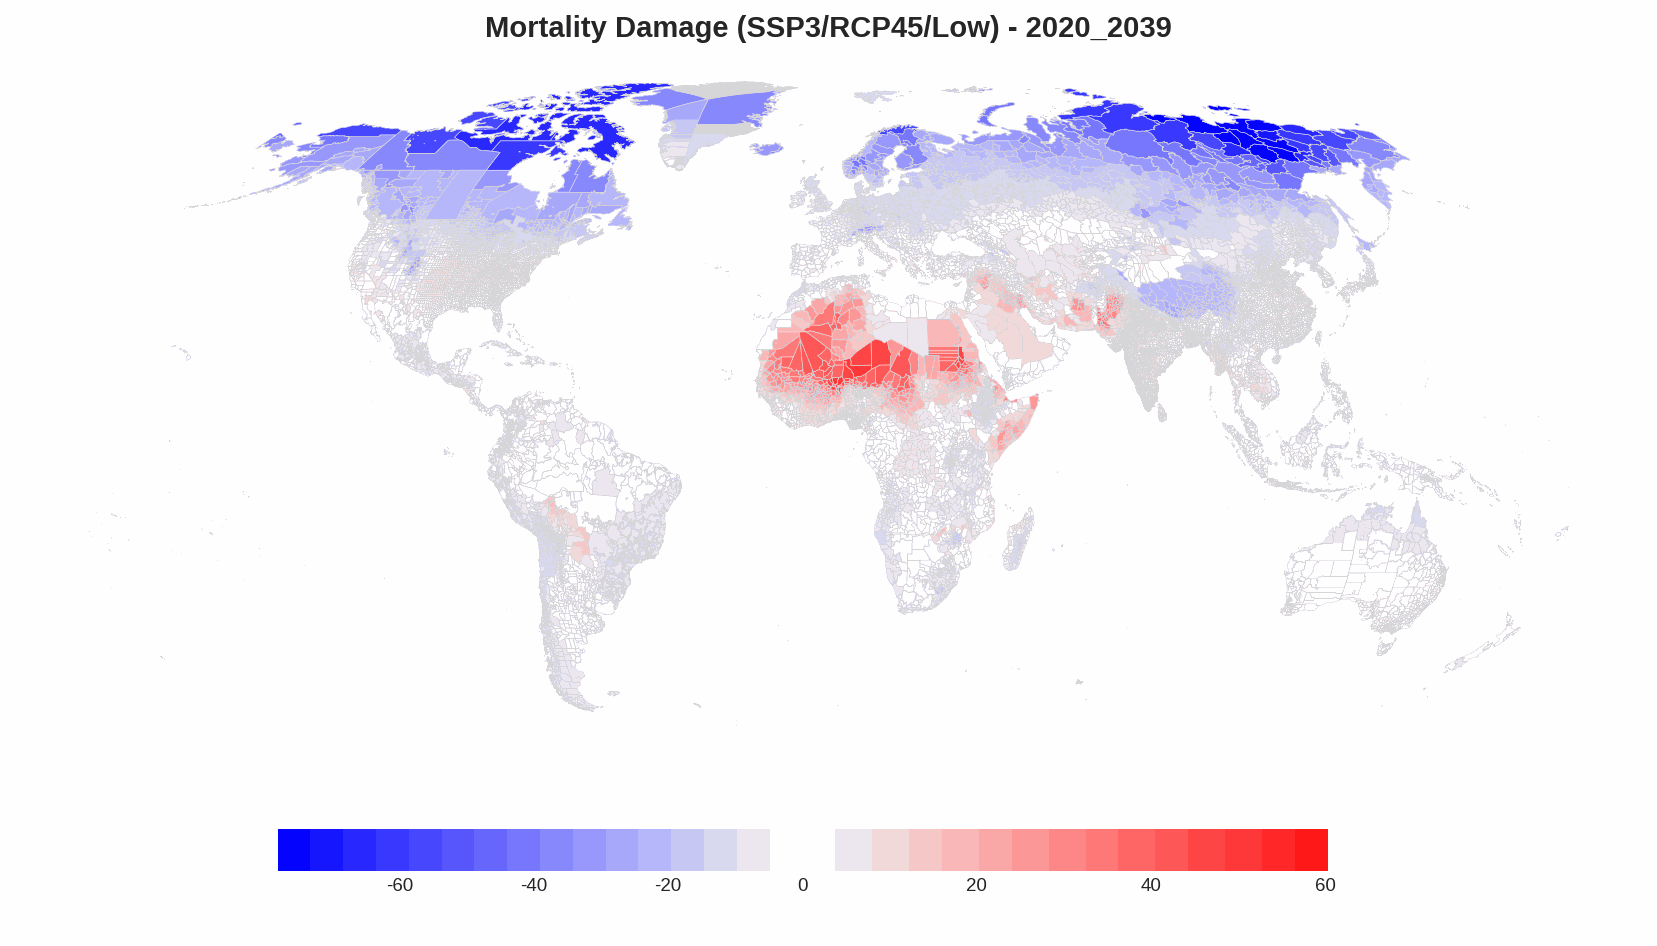

In [38]:
# Create animated GIF for impact region mortality (time series)
if os.path.exists(SHAPEFILE_PATH):
    ir_gif_path = ir_map_viz.create_time_series_gif(
        data=ir_mortality_df,
        time_col="period",
        value_col="rawtotal",
        geo_level="regional",
        geo_id_col="region",
        shapefile_path=SHAPEFILE_PATH,
        shape_id_col="hierid",
        title_template="Mortality Damage (SSP3/RCP45/Low) - {time_value}",
        units="deaths per 100k",
        vmin=ir_vmin_global,
        vmax=ir_vmax_global,
        duration=1500,  # 1.5 seconds per frame
        output_filename="ir_mortality_time_series.gif",
        figsize=(14, 7),
        exclude_patterns=["ATA"]
    )
    
    if ir_gif_path:
        print(f"Impact Region GIF saved to: {ir_gif_path}")
        display(Image(filename=ir_gif_path))
else:
    print("Shapefile not available. Skipping impact region GIF generation.")

## 10. Summary of Generated Outputs

Let's list all the outputs generated in this tutorial.

In [27]:
# List all generated outputs
print("=" * 60)
print("GENERATED OUTPUTS SUMMARY")
print("=" * 60)

# Mock data outputs
print("\nMock Data Maps (map_output/maps/):")
mock_dir = output_dir / "maps"
if mock_dir.exists():
    for f in sorted(os.listdir(mock_dir)):
        print(f"  - {f}")

# Country mortality outputs
print("\nCountry Mortality Maps (map_output/country_mortality/):")
if country_output_dir.exists():
    files = sorted(os.listdir(country_output_dir))
    # Show first few and last few to indicate range
    png_files = [f for f in files if f.endswith('.png')]
    gif_files = [f for f in files if f.endswith('.gif')]
    csv_files = [f for f in files if f.endswith('.csv')]
    
    print(f"  PNG maps: {len(png_files)} files")
    if png_files:
        print(f"    First: {png_files[0]}")
        print(f"    Last: {png_files[-1]}")
    print(f"  GIF animations: {len(gif_files)} files")
    for f in gif_files:
        print(f"    - {f}")
    print(f"  Statistics CSVs: {len(csv_files)} files")

# Impact region mortality outputs  
print("\nImpact Region Mortality Maps (map_output/impact_region_mortality/):")
if ir_output_dir.exists():
    files = sorted(os.listdir(ir_output_dir))
    png_files = [f for f in files if f.endswith('.png')]
    gif_files = [f for f in files if f.endswith('.gif')]
    csv_files = [f for f in files if f.endswith('.csv')]
    
    print(f"  PNG maps: {len(png_files)} files")
    for f in png_files:
        print(f"    - {f}")
    print(f"  GIF animations: {len(gif_files)} files")
    for f in gif_files:
        print(f"    - {f}")
    print(f"  Statistics CSVs: {len(csv_files)} files")

print("\n" + "=" * 60)

GENERATED OUTPUTS SUMMARY

Mock Data Maps (map_output/maps/):
  - comparison_flex_vs_raw_2100.png
  - comparison_flex_vs_raw_2100_stats.csv
  - country_flextotal_2100.png
  - country_flextotal_2100_stats.csv
  - country_flextotal_clipped.png
  - country_flextotal_clipped_stats.csv
  - country_presentation_style.png
  - country_presentation_style_stats.csv
  - country_rawtotal_2100.png
  - country_rawtotal_2100_stats.csv
  - f2_flextotal_2080.png
  - f2_flextotal_2080_stats.csv
  - regional_flextotal_2100.png
  - regional_flextotal_2100_stats.csv

Country Mortality Maps (map_output/country_mortality/):
  PNG maps: 20 files
    First: mortality_rcp45_high_2020_2039.png
    Last: mortality_rcp85_low_2095_2100.png
  GIF animations: 2 files
    - mortality_grid_animation.gif
    - mortality_rcp45_low_animation.gif
  Statistics CSVs: 20 files

Impact Region Mortality Maps (map_output/impact_region_mortality/):
  PNG maps: 5 files
    - ir_mortality_SSP3_rcp45_low_2020_2039.png
    - ir_morta